# Training environment information

In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           15Gi       1.1Gi       5.9Gi       0.0Ki       8.4Gi        13Gi
Swap:            0B          0B          0B


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f681717e-104c-0bdf-a084-652ab88ccf6c)


In [3]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz


In [4]:
!lscpu | grep 'Core(s) per socket:'

Core(s) per socket:              2


In [5]:
!nvidia-smi

Fri Jan  6 08:56:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


Preventing disconnect from Google Colab notebook:
Right-click on the connect button and paste the code to the console of the UI:


```
function ClickConnect(){
    console.log("Clicked on connect button");
    document.querySelector("colab-connect-button").click() 
 }
 setInterval(ClickConnect,60000)
```

# Setup

In [7]:
!pip install fastai==2.5.3 -q
!pip freeze

anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1666191106763/work/dist
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1666850859330/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1659291887007/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1649463573192/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1656355450470/work
blis==0.7.9
catalogue==2.0.8
certifi==2022.12.7
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1666754707314/work
charset-normalizer==2.1.1
click==8.1.3
confection==0.0.3
contourpy==1.0.6
cycler==0.11

In [8]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
import sys

In [9]:
# Load EB_ML python libraries
# The following libraries are used in this notebook and should be installed in your local machine before running this notebook.
# eb_colab_utils.py
# eb_ml_battery_lib.py
# eb_ml_utils.py

# path to load external *.py files used in this notebook
# Note: in Google Colab virtual machine you shoud copy the files in "/content" folder after BEFORE running this notebook's cell
external_python_file_path="/home/studio-lab-user/code"
sys.path.append(external_python_file_path)


from ml4measurement.eb_ml_colab_utils import get_root_path,copy_model_to_google_drive
from ml4measurement.eb_ml_battery_lib import generate_image_files_from_measure_table
from ml4measurement.eb_ml_utils import build_and_train_learner,save_model_weights,build_data_loader,score_model


In [10]:
import yaml

config_file = '../config/config.yaml'

#Read the configuration
with open(config_file) as cfg_file:
    config = yaml.load(stream = cfg_file, Loader = yaml.FullLoader)

classification_results_out = config['classification_results_out']
pca_scatter_plots_out = config['pca_scatter_plots_out']

# Training Configuration

In [12]:
config

{'freq_table_src': '../data/frequencies.csv',
 'meas_table_src': '../datasets/EIS-vs-SOC-jun2022/impedance.csv',
 'models_path': '../models',
 'battery_id_field': 'BATTERY_ID',
 'measure_id_field': 'MEASURE_ID',
 'frequency_id_field': 'FREQUENCY_ID',
 'soc_field': 'SOC',
 'impedance_field': 'IMPEDANCE_VALUE',
 'classification_results_out': '../results/classification-results.txt',
 'pca_scatter_plots_out': '../results/scatter-plots.svg',
 'working_folder': '/home/studio-lab-user/',
 'soc_list': ['100',
  '090',
  '080',
  '070',
  '060',
  '050',
  '040',
  '030',
  '020',
  '010'],
 'all_batteries': ['02_4',
  '02_5',
  '02_6',
  '02_7',
  '02_8',
  '02_9',
  '03_4',
  '03_5',
  '03_6',
  '03_7',
  '03_8',
  '03_9',
  '05_3',
  '05_4',
  '05_5',
  '05_6',
  '05_7'],
 'cross_validation_list': [['02_4', '02_5', '02_6', '02_7', '02_8', '02_9'],
  ['03_4', '03_5', '03_6', '03_7', '03_8', '03_9'],
  ['05_3', '05_4', '05_5', '05_6', '05_7']],
 'cross_validation_experiment_names': ['02', '03'

In [13]:
#configuration dictionary

# Map the worming folder to Google Drive is running in Google Colab environment
config['ROOT_DIR'] = get_root_path(config['working_folder'])


NOT running on COLAB


## Leave One Battery Out

In [14]:
from itertools import product
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from LiBEIS.code.utilities import read_measurement_table,FeatureExtractionMode,DataNormaliser,get_patterns

#Note: Some pattern_extraction_mode values are disabled to avoid  exceeding 
# the computation time limit of Code Ocean 
pattern_extraction_modes =\
    [#FeatureExtractionMode(mode = 'module'),
     #FeatureExtractionMode(mode = 'phase'),
     FeatureExtractionMode(mode = 'module+phase'),
     #FeatureExtractionMode(mode = 'real'),
     #FeatureExtractionMode(mode = 'imag'),
     FeatureExtractionMode(mode = 'real+imag')]



# Normalization is not compatible with data augmentation
normalization_modes =\
    [DataNormaliser(name = 'None', model = None),
     #DataNormaliser(name = 'MinMax', model = MinMaxScaler),
     #DataNormaliser(name = 'Z-score', model = StandardScaler)
    ]

data_agumentation_factors = [20]

#Generate a full factorial plan by pattern_extraction_modes x classifiers
factorial_plan = product(pattern_extraction_modes, normalization_modes,data_agumentation_factors)

factorial_plan = list(factorial_plan)
num_experiments = len(factorial_plan)

In [15]:

# Load dataset using LiBEIS 
_, meas_table_wide, battery_id_col_name, freq_id_col_name, impedance_col_name, measure_id_col_name, soc_col_name = read_measurement_table(config_file)

indices = np.arange(meas_table_wide.shape[0]).astype(np.uint)


/home/studio-lab-user/code/LiBEIS/code/utilities.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  meas_table_wide = meas_table_tall.pivot(primary_key, freq_id_col_name)


In [16]:
meas_table_wide

MEASURE_ID  SOC BATTERY_ID     IMPEDANCE_VALUE  \
FREQUENCY_ID                                              0   
0                  02_4   10          2  0.117933-0.006453j   
1                  02_4   20          2  0.108914-0.004577j   
2                  02_4   30          2  0.105084-0.003881j   
3                  02_4   40          2  0.104545-0.003870j   
4                  02_4   50          2  0.103768-0.004256j   
..                  ...  ...        ...                 ...   
235                06_8   60          6  0.105475-0.005807j   
236                06_8   70          6  0.104604-0.006193j   
237                06_8   80          6  0.103358-0.005761j   
238                06_8   90          6  0.103680-0.005234j   
239                06_8  100          6  0.102012-0.004807j   

                                                                          \
FREQUENCY_ID                   1                   2                   3   
0             0.115688-0.005226j  0.114258-0.004235j  0.113243-0.003809j   
1             0.107390-0.003691j  0.106296-0.002381j  0.105806-0.002027j   
2             0.103869-0.003199j  0.103098-0.002013j  0.102843-0.001713j   
3             0.103324-0.002926j  0.102673-0.002098j  0.102103-0.001555j   
4             0.102449-0.003355j  0.101666-0.002424j  0.101108-0.001858j   
..                           ...                 ...                 ...   
235           0.103037-0.005163j  0.101439-0.003260j  0.100950-0.002266j   
236           0.102764-0.004643j  0.101474-0.003235j  0.100668-0.002506j   
237           0.101491-0.004417j  0.100160-0.003028j  0.099628-0.002222j   
238           0.102111-0.004055j  0.100888-0.002762j  0.100350-0.002017j   
239           0.101459-0.002807j  0.100853-0.002208j  0.100232-0.001664j   

                                                                          \
FREQUENCY_ID                   4                   5                   6   
0             0.111026-0.004652j  0.109057-0.005699j  0.106340-0.006653j   
1             0.104751-0.002257j  0.103965-0.002888j  0.102727-0.004009j   
2             0.101968-0.001720j  0.101440-0.002340j  0.100473-0.003114j   
3             0.101310-0.001838j  0.100783-0.002343j  0.100185-0.002937j   
4             0.099993-0.001833j  0.099596-0.002300j  0.099106-0.002856j   
..                           ...                 ...                 ...   
235           0.099744-0.002003j  0.099114-0.002131j  0.098424-0.002288j   
236           0.099592-0.001932j  0.098702-0.002253j  0.098120-0.002294j   
237           0.098459-0.001881j  0.097915-0.001947j  0.097327-0.002187j   
238           0.099374-0.001809j  0.098816-0.001959j  0.098189-0.002165j   
239           0.099547-0.001447j  0.099191-0.001673j  0.098627-0.002070j   

                                                                          \
FREQUENCY_ID                   7                   8                   9   
0             0.101733-0.007526j  0.097836-0.007710j  0.094492-0.007356j   
1             0.099835-0.005825j  0.096654-0.006610j  0.093300-0.006884j   
2             0.098450-0.004741j  0.095612-0.006006j  0.092412-0.006553j   
3             0.097745-0.004520j  0.095411-0.005965j  0.092198-0.006490j   
4             0.096909-0.004247j  0.094556-0.005593j  0.091448-0.006259j   
..                           ...                 ...                 ...   
235           0.096977-0.003218j  0.095176-0.004172j  0.092986-0.004747j   
236           0.096754-0.003253j  0.095009-0.003961j  0.092899-0.004740j   
237           0.096023-0.002886j  0.094421-0.003751j  0.092544-0.004401j   
238           0.096783-0.003066j  0.095252-0.004004j  0.093130-0.004682j   
239           0.097250-0.003201j  0.095518-0.004299j  0.093175-0.004895j   

                                                                          \
FREQUENCY_ID                  10                  11                  12   
0             0.090119-0.006749j  0.086891-0.006165j  0.084373-0.005057j  

Running experiment 1 of 2
battery data acquisitions for training and validation: 
['03_4', '03_5', '03_6', '03_7', '03_8', '03_9', '05_3', '05_4', '05_5', '05_6', '05_7']
battery data acquisitions for test: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9']
model name: Paper_MES_leave_one_out_02_Exp_0
dataset row number: 110
start image file generation. IMAGE_PATH: ../Paper_MES_leave_one_out_02_Exp_0
soc: 10
measure: 03_4
augmentation_index: 0
../Paper_MES_leave_one_out_02_Exp_0/Paper_MES_leave_one_out_02_Exp_0-03_4_10.png
augmentation_index: 1
../Paper_MES_leave_one_out_02_Exp_0/Paper_MES_leave_one_out_02_Exp_0-1100_10.png
augmentation_index: 2
../Paper_MES_leave_one_out_02_Exp_0/Paper_MES_leave_one_out_02_Exp_0-1200_10.png
augmentation_index: 3
../Paper_MES_leave_one_out_02_Exp_0/Paper_MES_leave_one_out_02_Exp_0-1300_10.png
augmentation_index: 4
../Paper_MES_leave_one_out_02_Exp_0/Paper_MES_leave_one_out_02_Exp_0-1400_10.png
augmentation_index: 5
../Paper_MES_leave_one_out_02_Exp_0/Pa

Valley: 1.45e-03


saved filename: Paper_MES_leave_one_out_02_Exp_0_1672995954.942681_SAVED.pth
Setting-up type transforms pipelines
Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../Paper_MES_leave_one_out_02_Exp_0/Paper_MES_leave_one_out_02_Exp_0-1696_70.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../Paper_MES_leave_one_out_02_Exp_0/Paper_MES_leave_one_out_02_Exp_0-1696_70.png
    applying RegexLabeller gives
      70
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(7))


Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILB

[[49  0  0  0  0  0  0  0  0  0]
 [ 0 62  0  0  0  0  0  0  0  0]
 [ 0  0 69  0  0  0  0  0  0  0]
 [ 0  0  0 54  0  0  0  0  0  0]
 [ 0  0  0  0 62  0  0  0  0  0]
 [ 0  0  0  0  0 66  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 66  2  1]
 [ 0  0  0  0  0  0  0  0 59  0]
 [ 0  0  0  0  0  0  0  0  0 66]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0. 

learn.validate()


Model accuracy: 1.00
learn.get_preds()


battery data acquisitions for training and validation: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9', '05_3', '05_4', '05_5', '05_6', '05_7']
battery data acquisitions for test: 
['03_4', '03_5', '03_6', '03_7', '03_8', '03_9']
model name: Paper_MES_leave_one_out_03_Exp_0
dataset row number: 110
start image file generation. IMAGE_PATH: ../Paper_MES_leave_one_out_03_Exp_0
soc: 10
measure: 02_4
augmentation_index: 0
../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_Exp_0-02_4_10.png
augmentation_index: 1
../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_Exp_0-1100_10.png
augmentation_index: 2
../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_Exp_0-1200_10.png
augmentation_index: 3
../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_Exp_0-1300_10.png
augmentation_index: 4
../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_Exp_0-1400_10.png
augmentation_index: 5
../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_E

Valley: 2.09e-03


saved filename: Paper_MES_leave_one_out_03_Exp_0_1672996535.712938_SAVED.pth
Setting-up type transforms pipelines
Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_Exp_0-1696_70.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../Paper_MES_leave_one_out_03_Exp_0/Paper_MES_leave_one_out_03_Exp_0-1696_70.png
    applying RegexLabeller gives
      70
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(7))


Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILB

[[49  0  0  0  0  0  0  0  0  0]
 [ 0 62  0  0  0  0  0  0  0  0]
 [ 0  0 69  0  0  0  0  0  0  0]
 [ 0  0  0 54  0  0  0  0  0  0]
 [ 0  0  0  0 62  0  0  0  0  0]
 [ 0  0  0  0  0 66  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 67  2  0]
 [ 0  0  0  0  0  0  0  0 59  0]
 [ 0  0  0  0  0  0  0  0  0 66]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0. 

learn.validate()


Model accuracy: 1.00
learn.get_preds()


battery data acquisitions for training and validation: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9', '03_4', '03_5', '03_6', '03_7', '03_8', '03_9']
battery data acquisitions for test: 
['05_3', '05_4', '05_5', '05_6', '05_7']
model name: Paper_MES_leave_one_out_05_Exp_0
dataset row number: 120
start image file generation. IMAGE_PATH: ../Paper_MES_leave_one_out_05_Exp_0
soc: 10
measure: 02_4
augmentation_index: 0
../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_Exp_0-02_4_10.png
augmentation_index: 1
../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_Exp_0-1100_10.png
augmentation_index: 2
../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_Exp_0-1200_10.png
augmentation_index: 3
../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_Exp_0-1300_10.png
augmentation_index: 4
../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_Exp_0-1400_10.png
augmentation_index: 5
../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_E

Valley: 1.74e-03


saved filename: Paper_MES_leave_one_out_05_Exp_0_1672997122.931737_SAVED.pth
Setting-up type transforms pipelines
Found 2040 items
2 datasets of sizes 1428,612
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_Exp_0-2110_10.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../Paper_MES_leave_one_out_05_Exp_0/Paper_MES_leave_one_out_05_Exp_0-2110_10.png
    applying RegexLabeller gives
      10
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(0))


Found 2040 items
2 datasets of sizes 1428,612
Setting up Pipeline: PILB

[[62  0  0  0  0  0  0  2  0  0]
 [ 0 48  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  0  0 65  0  0  0  0  0  0]
 [ 0  0  0  0 55  0  0  0  0  0]
 [ 0  0  0  0  0 60  0  0  0  0]
 [ 0  0  0  0  0  0 67  0  0  0]
 [ 0  0  0  0  0  0  0 65  0  0]
 [ 0  0  0  0  0  0  0  0 60  0]
 [ 0  0  0  0  0  0  0  0  0 71]]
[[0.96875 0.      0.      0.      0.      0.      0.      0.03125 0.
  0.     ]
 [0.      1.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      1.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      1.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      1.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      1.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      1.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.      1.      0.
  0.     ]
 [0.      0.      0.      0. 

learn.validate()


Model accuracy: 1.00
learn.get_preds()


Running experiment 2 of 2
battery data acquisitions for training and validation: 
['03_4', '03_5', '03_6', '03_7', '03_8', '03_9', '05_3', '05_4', '05_5', '05_6', '05_7']
battery data acquisitions for test: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9']
model name: Paper_MES_leave_one_out_02_Exp_1
dataset row number: 110
start image file generation. IMAGE_PATH: ../Paper_MES_leave_one_out_02_Exp_1
soc: 10
measure: 03_4
augmentation_index: 0
../Paper_MES_leave_one_out_02_Exp_1/Paper_MES_leave_one_out_02_Exp_1-03_4_10.png
augmentation_index: 1
../Paper_MES_leave_one_out_02_Exp_1/Paper_MES_leave_one_out_02_Exp_1-1100_10.png
augmentation_index: 2
../Paper_MES_leave_one_out_02_Exp_1/Paper_MES_leave_one_out_02_Exp_1-1200_10.png
augmentation_index: 3
../Paper_MES_leave_one_out_02_Exp_1/Paper_MES_leave_one_out_02_Exp_1-1300_10.png
augmentation_index: 4
../Paper_MES_leave_one_out_02_Exp_1/Paper_MES_leave_one_out_02_Exp_1-1400_10.png
augmentation_index: 5
../Paper_MES_leave_one_out_02_Exp_1/Pa

Valley: 1.74e-03


saved filename: Paper_MES_leave_one_out_02_Exp_1_1672997700.030707_SAVED.pth
Setting-up type transforms pipelines
Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../Paper_MES_leave_one_out_02_Exp_1/Paper_MES_leave_one_out_02_Exp_1-1696_70.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../Paper_MES_leave_one_out_02_Exp_1/Paper_MES_leave_one_out_02_Exp_1-1696_70.png
    applying RegexLabeller gives
      70
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(7))


Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILB

[[49  0  0  0  0  0  0  0  0  0]
 [ 0 61  0  0  0  1  0  0  0  0]
 [ 0  0 69  0  0  0  0  0  0  0]
 [ 0  0  0 48  6  0  0  0  0  0]
 [ 0  0  0  6 54  2  0  0  0  0]
 [ 0  0  1  0  0 65  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 55 14  0]
 [ 0  0  0  0  0  0  0  9 46  4]
 [ 0  0  0  0  0  0  0  0  2 64]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.98387097 0.         0.         0.         0.01612903
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.88888889 0.11111111 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.09677419 0.87096774 0.03225806
  0.         0.         0.         0.        ]
 [0.         0.         0.01515152 0.         0.         0.98484848
  0.         0.         0.         0.        ]
 [0

learn.validate()


Model accuracy: 0.93
learn.get_preds()


battery data acquisitions for training and validation: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9', '05_3', '05_4', '05_5', '05_6', '05_7']
battery data acquisitions for test: 
['03_4', '03_5', '03_6', '03_7', '03_8', '03_9']
model name: Paper_MES_leave_one_out_03_Exp_1
dataset row number: 110
start image file generation. IMAGE_PATH: ../Paper_MES_leave_one_out_03_Exp_1
soc: 10
measure: 02_4
augmentation_index: 0
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-02_4_10.png
augmentation_index: 1
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1100_10.png
augmentation_index: 2
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1200_10.png
augmentation_index: 3
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1300_10.png
augmentation_index: 4
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1400_10.png
augmentation_index: 5
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_E

/home/studio-lab-user/code/ml4measurement/eb_ml_utils.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


augmentation_index: 6
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1600_10.png
augmentation_index: 7
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1700_10.png
augmentation_index: 8
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1800_10.png
augmentation_index: 9
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1900_10.png
augmentation_index: 10
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-2000_10.png
augmentation_index: 11
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-2100_10.png
augmentation_index: 12
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-2200_10.png
augmentation_index: 13
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-2300_10.png
augmentation_index: 14
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-2400_10.png
augmentation_index: 15
../Paper_MES_leave_one_out_03_Exp_1/Paper_MES

Valley: 8.32e-04


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fastai/callback/schedule.py:264: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


saved filename: Paper_MES_leave_one_out_03_Exp_1_1672998278.551248_SAVED.pth
Setting-up type transforms pipelines
Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1696_70.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../Paper_MES_leave_one_out_03_Exp_1/Paper_MES_leave_one_out_03_Exp_1-1696_70.png
    applying RegexLabeller gives
      70
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(7))


Found 2020 items
2 datasets of sizes 1414,606
Setting up Pipeline: PILB

[[49  0  0  0  0  0  0  0  0  0]
 [ 0 61  1  0  0  0  0  0  0  0]
 [ 0  0 69  0  0  0  0  0  0  0]
 [ 0  0  0 46  8  0  0  0  0  0]
 [ 0  0  0  8 53  1  0  0  0  0]
 [ 0  0  0  0  1 65  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 54 15  0]
 [ 0  0  0  0  0  0  0  5 54  0]
 [ 0  0  0  0  0  0  0  0  1 65]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.98387097 0.01612903 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.85185185 0.14814815 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.12903226 0.85483871 0.01612903
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.01515152 0.98484848
  0.         0.         0.         0.        ]
 [0.       

learn.validate()


Model accuracy: 0.93
learn.get_preds()


battery data acquisitions for training and validation: 
['02_4', '02_5', '02_6', '02_7', '02_8', '02_9', '03_4', '03_5', '03_6', '03_7', '03_8', '03_9']
battery data acquisitions for test: 
['05_3', '05_4', '05_5', '05_6', '05_7']
model name: Paper_MES_leave_one_out_05_Exp_1
dataset row number: 120
start image file generation. IMAGE_PATH: ../Paper_MES_leave_one_out_05_Exp_1
soc: 10
measure: 02_4
augmentation_index: 0
../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_Exp_1-02_4_10.png
augmentation_index: 1
../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_Exp_1-1100_10.png
augmentation_index: 2
../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_Exp_1-1200_10.png
augmentation_index: 3
../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_Exp_1-1300_10.png
augmentation_index: 4
../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_Exp_1-1400_10.png
augmentation_index: 5
../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_E

Valley: 5.75e-04


saved filename: Paper_MES_leave_one_out_05_Exp_1_1672998858.479626_SAVED.pth
Setting-up type transforms pipelines
Found 2040 items
2 datasets of sizes 1428,612
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_Exp_1-2110_10.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../Paper_MES_leave_one_out_05_Exp_1/Paper_MES_leave_one_out_05_Exp_1-2110_10.png
    applying RegexLabeller gives
      10
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(0))


Found 2040 items
2 datasets of sizes 1428,612
Setting up Pipeline: PILB

[[64  0  0  0  0  0  0  0  0  0]
 [ 0 48  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  0  0 53 12  0  0  0  0  0]
 [ 0  0  0  6 47  2  0  0  0  0]
 [ 0  0  0  0  3 57  0  0  0  0]
 [ 0  0  0  0  0  0 66  1  0  0]
 [ 0  0  0  0  0  0  0 56  9  0]
 [ 0  0  0  0  0  0  0  6 53  1]
 [ 0  0  0  0  0  0  0  0  1 70]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.81538462 0.18461538 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.10909091 0.85454545 0.03636364
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.05       0.95
  0.         0.         0.         0.        ]
 [0.         0.  

learn.validate()


Model accuracy: 0.93
learn.get_preds()


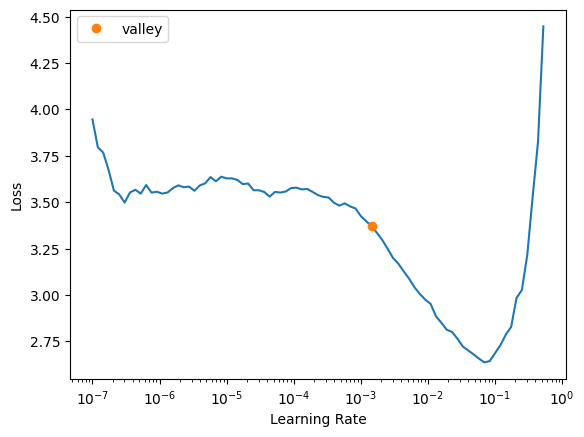

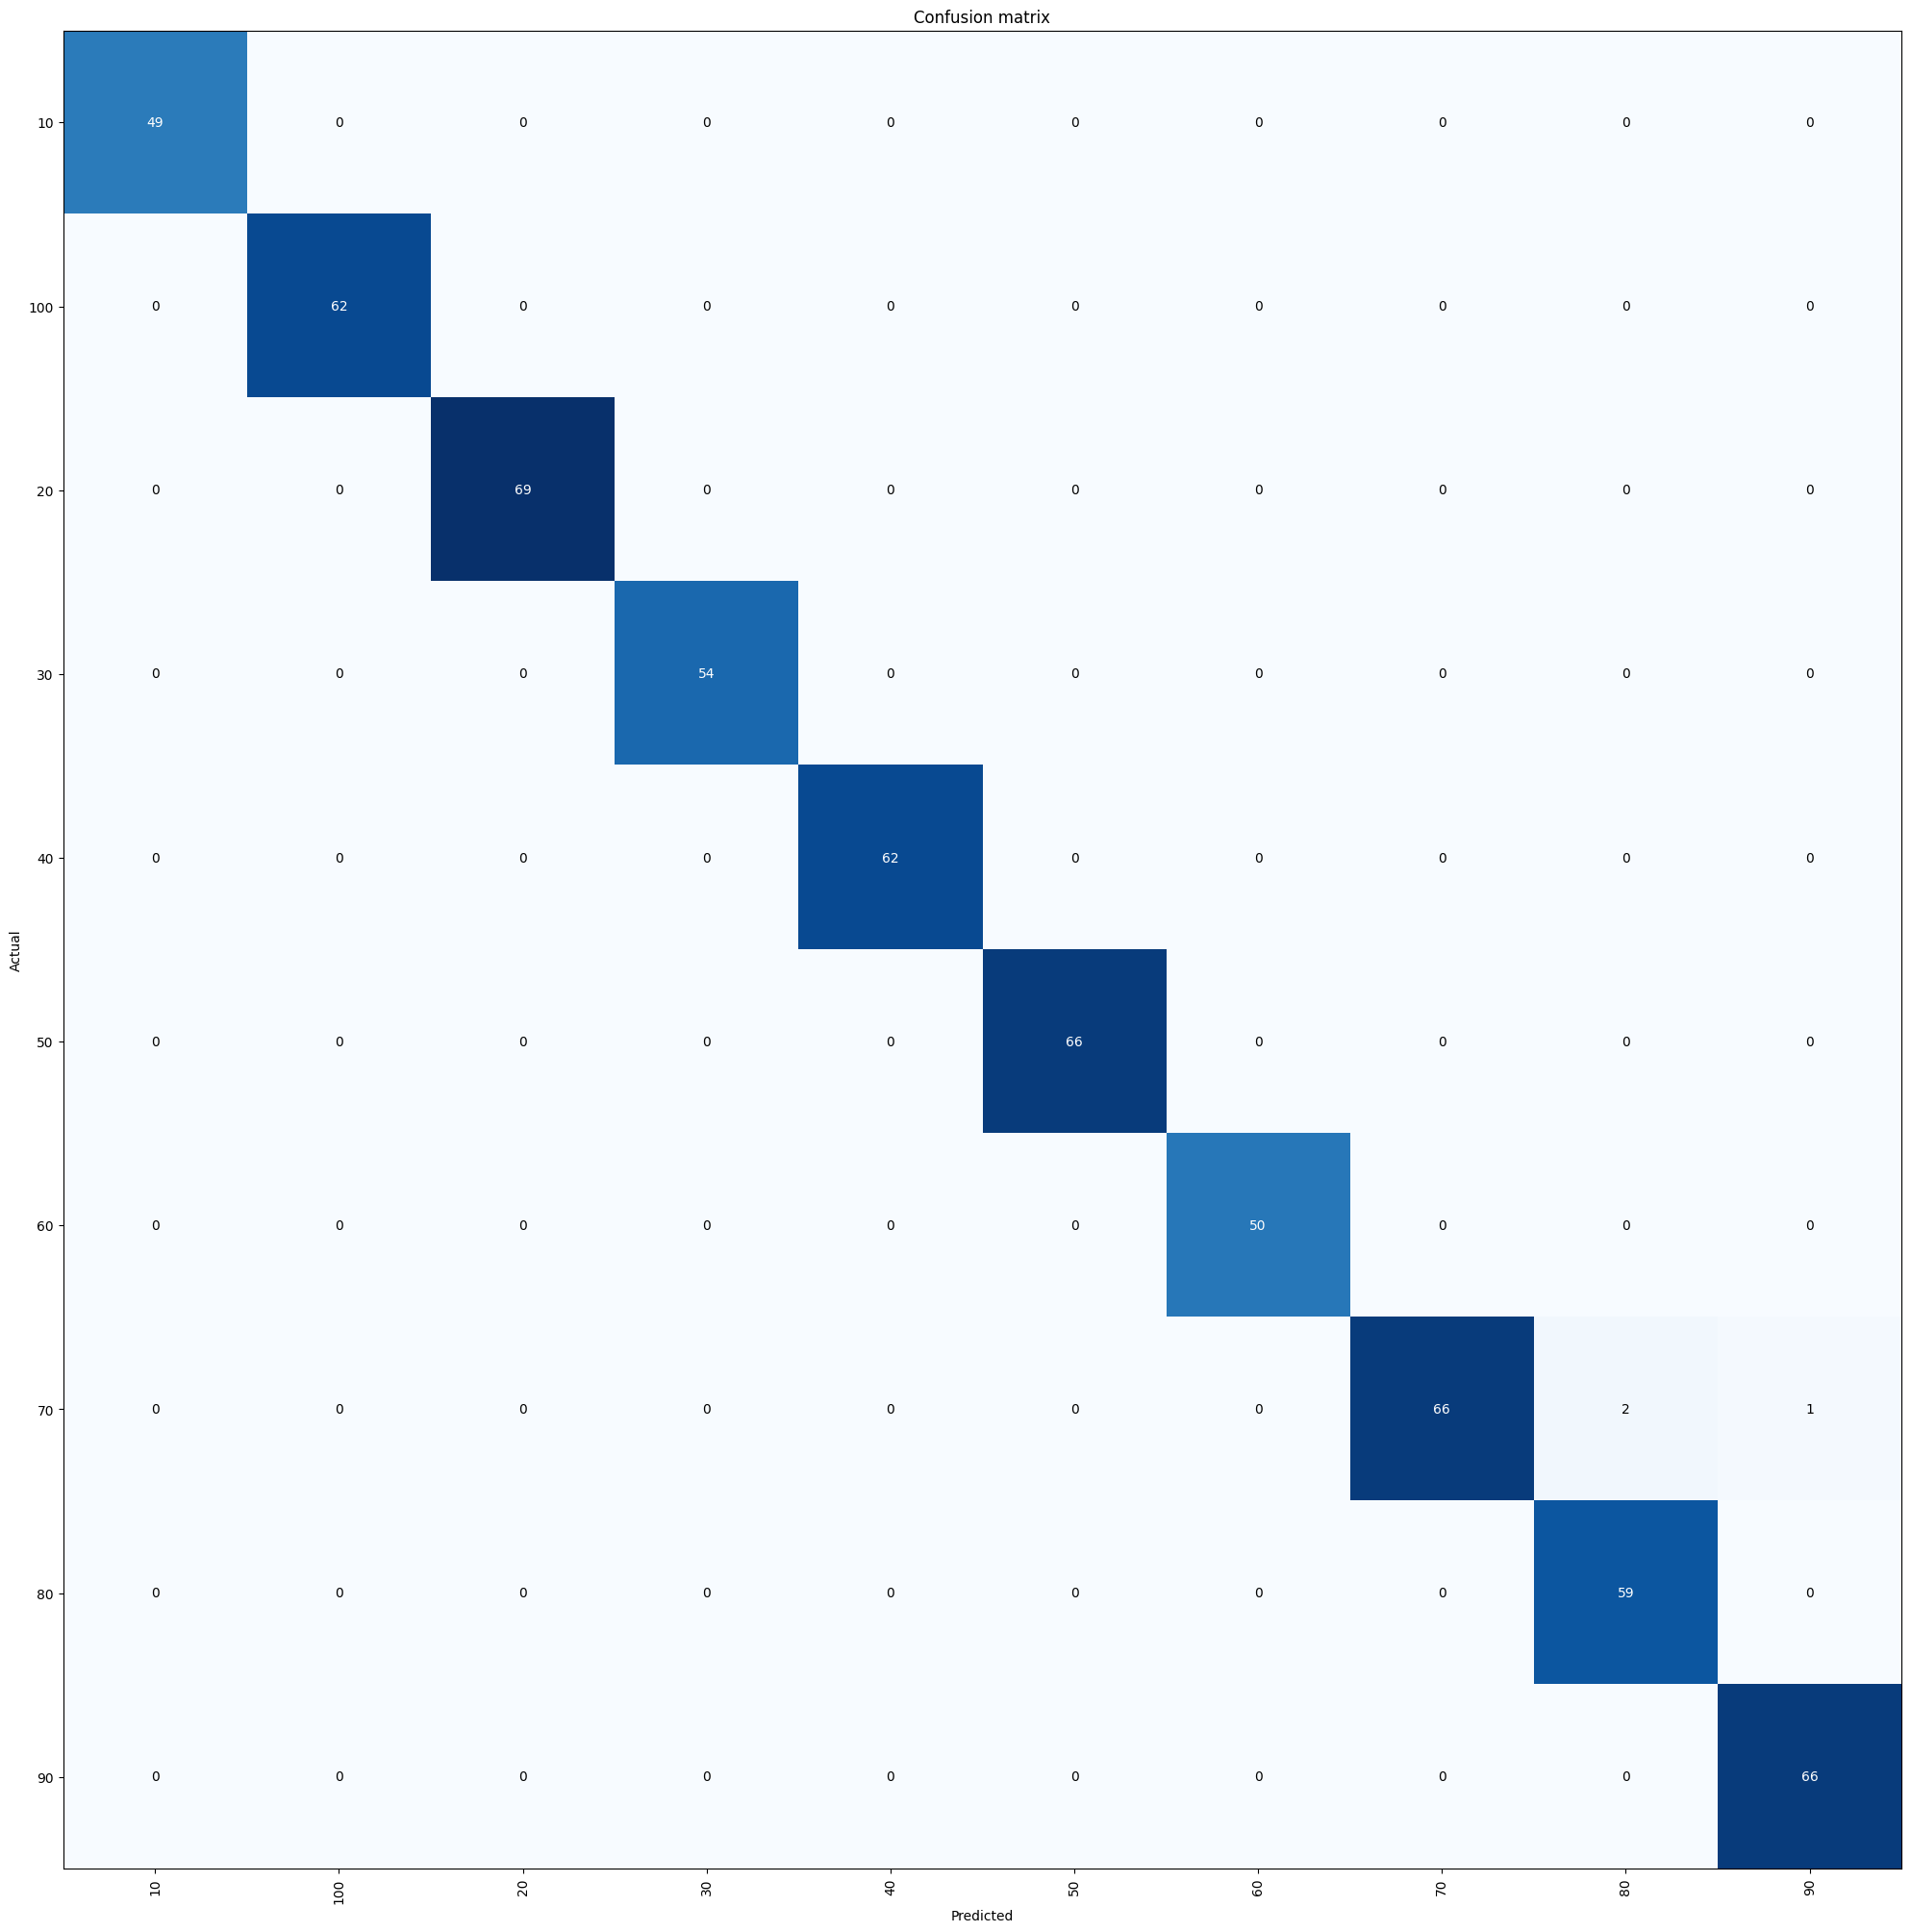

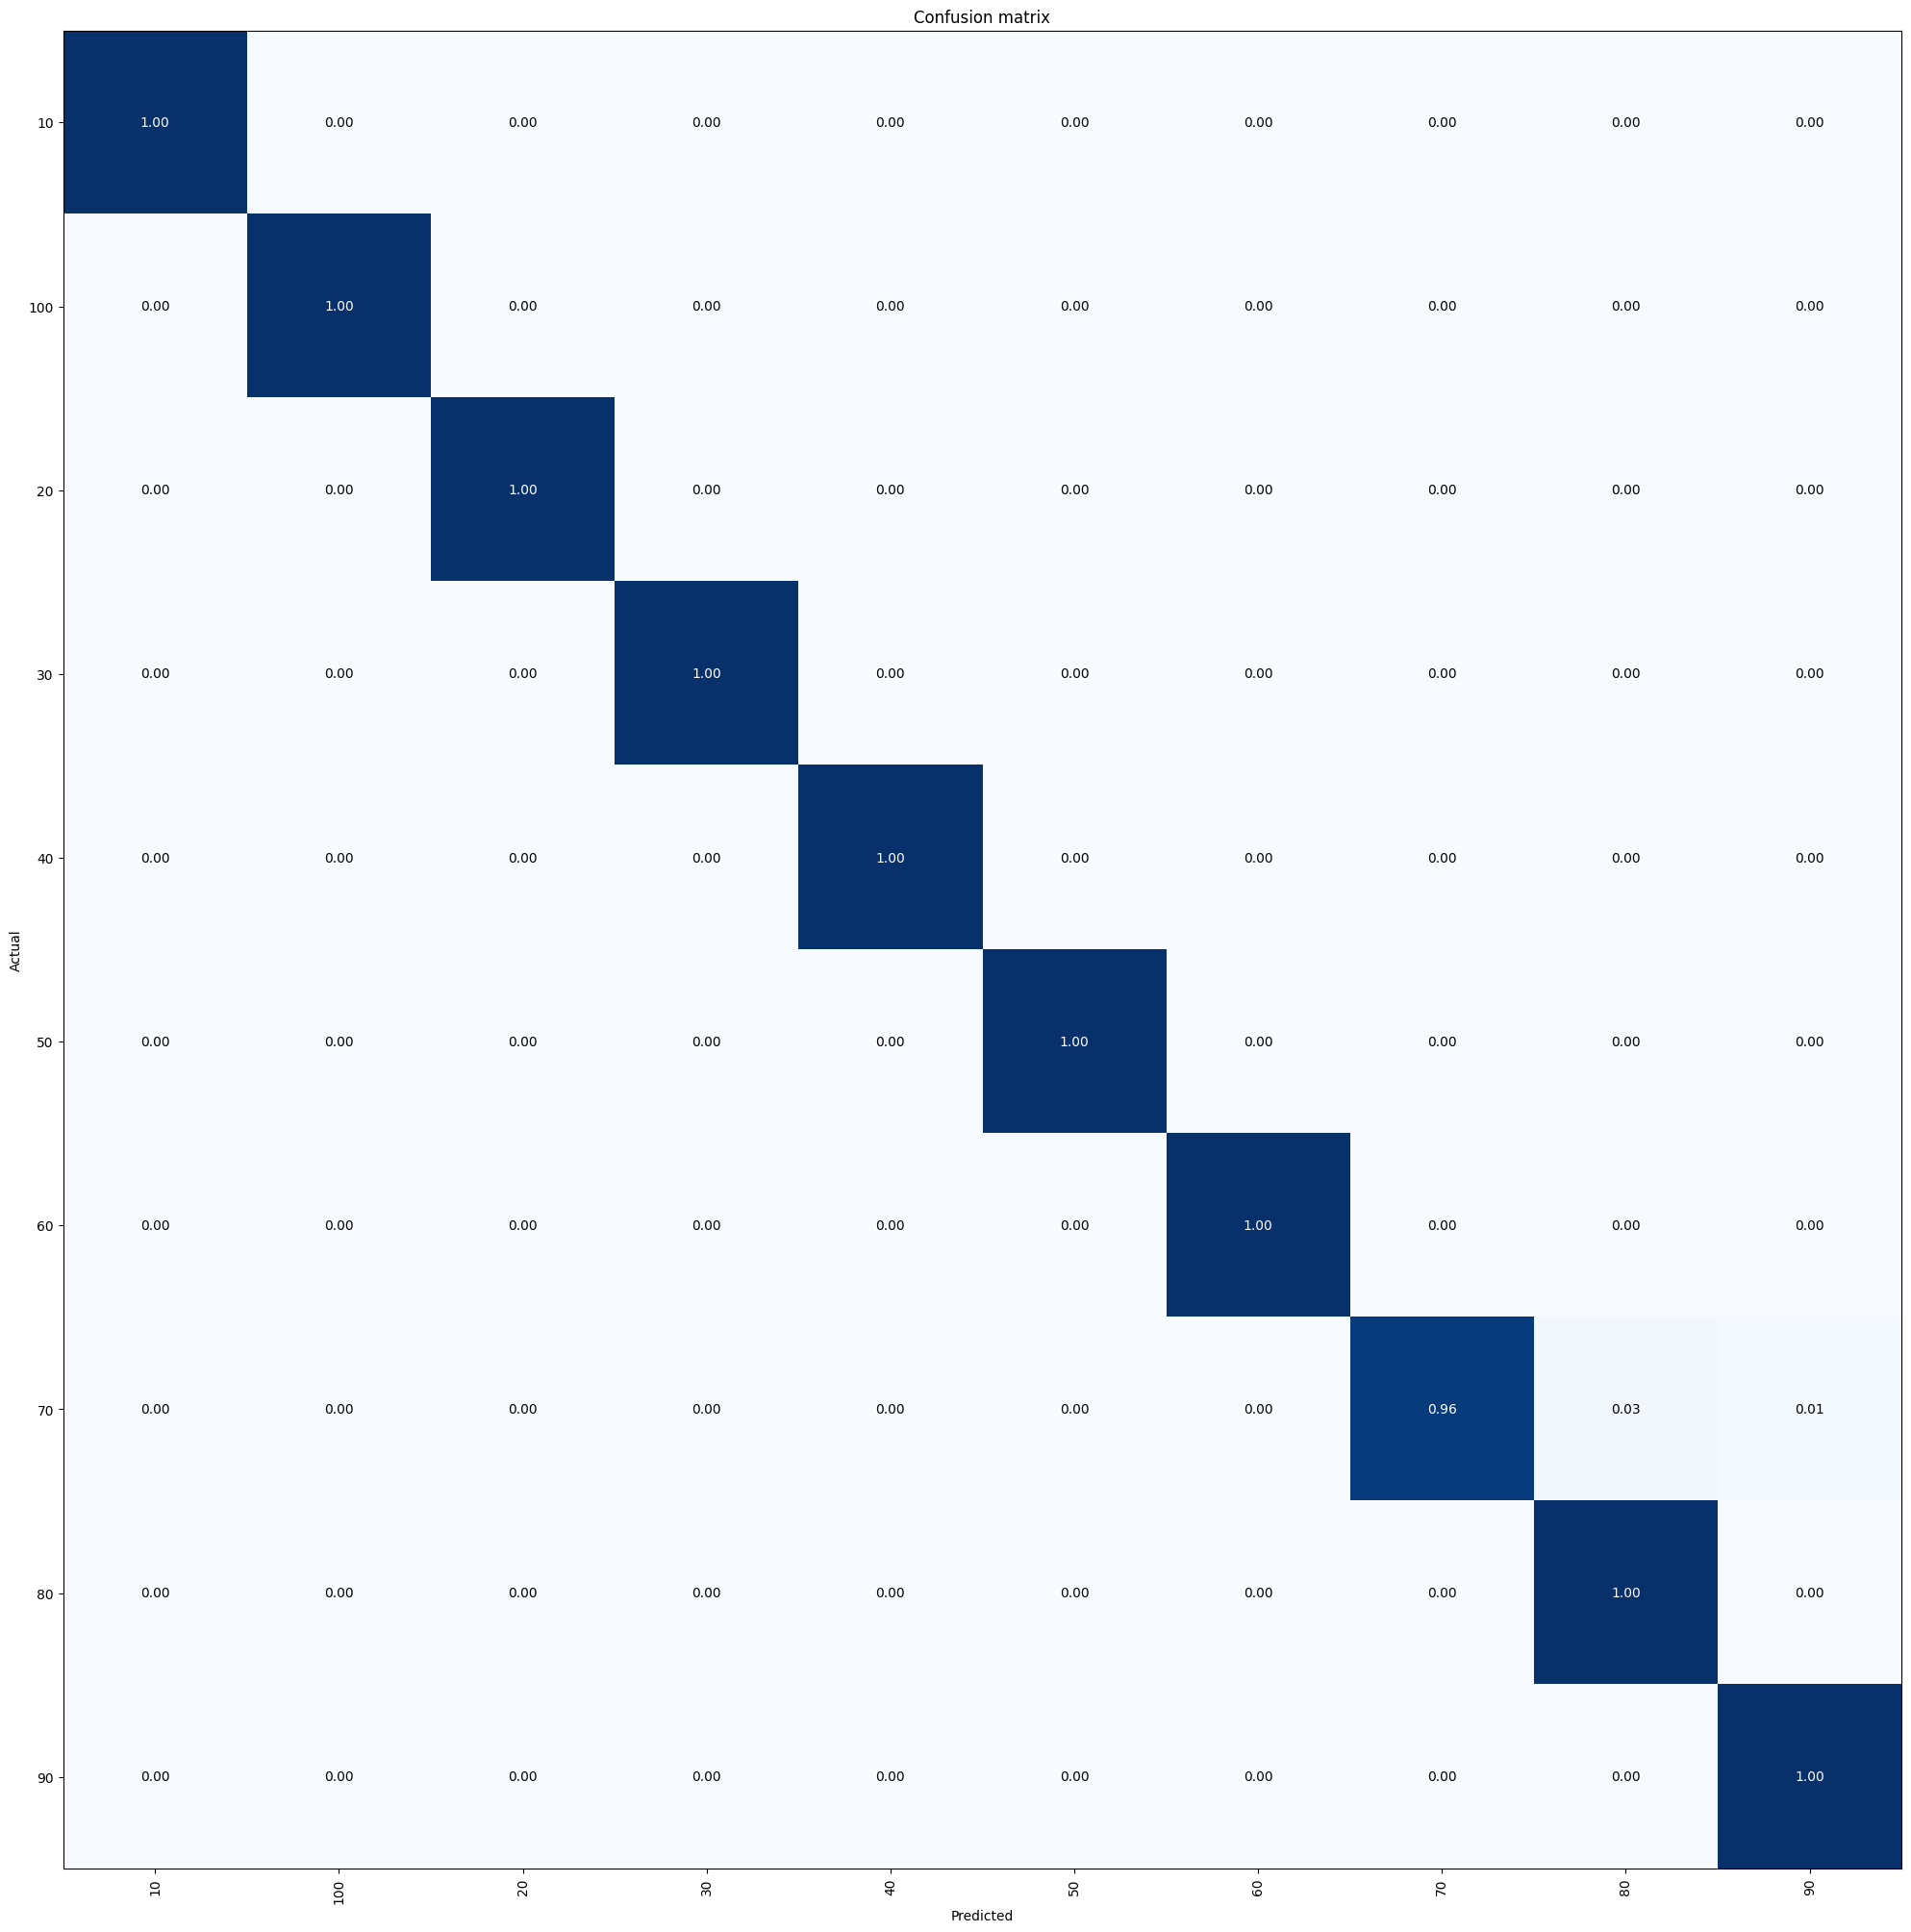

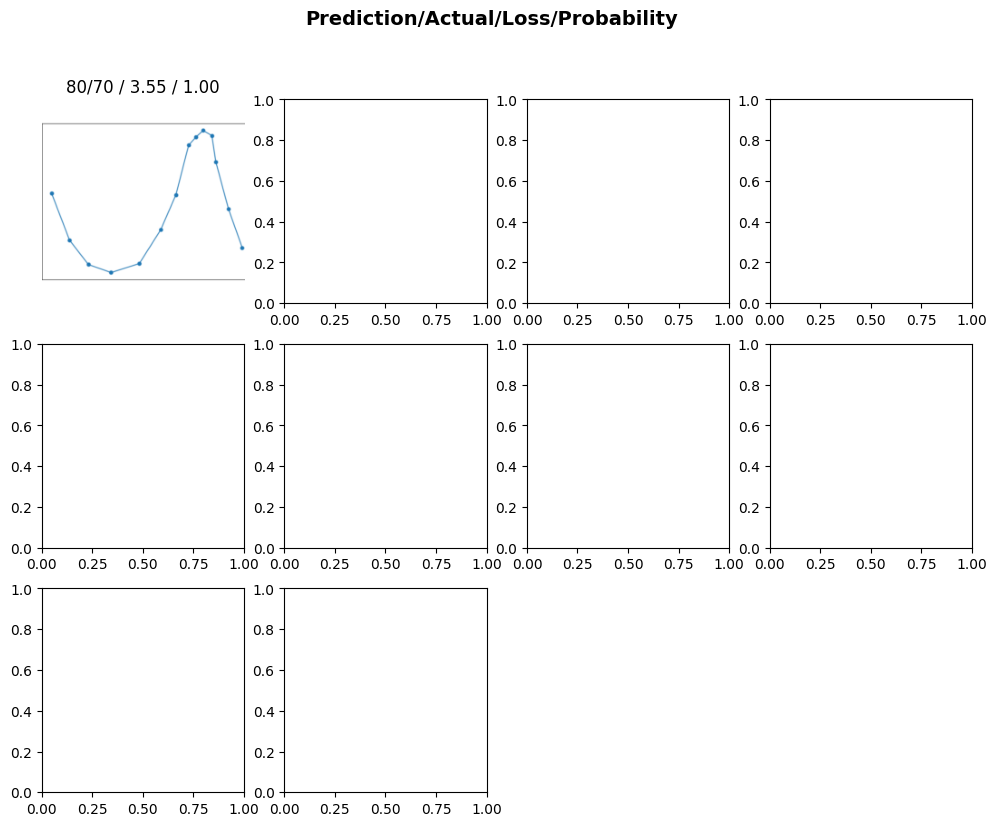

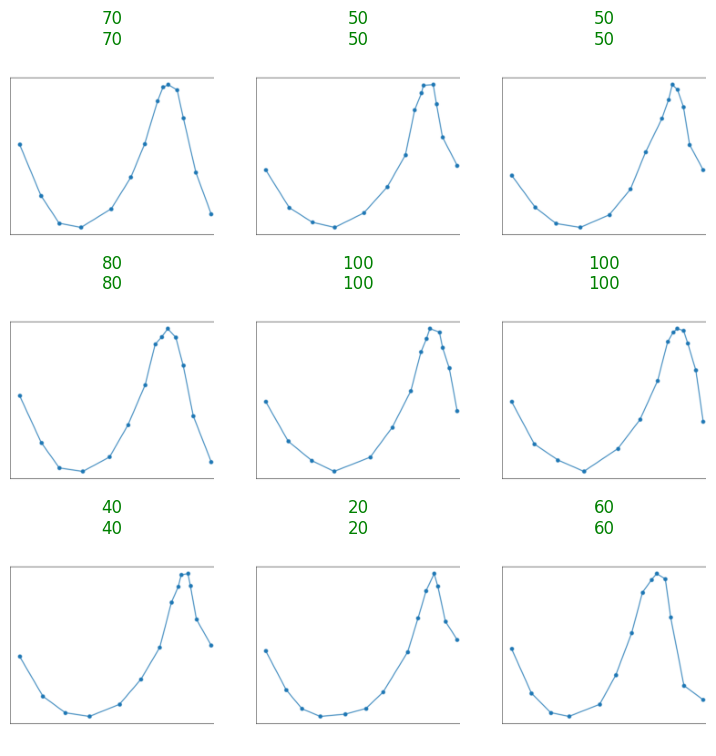

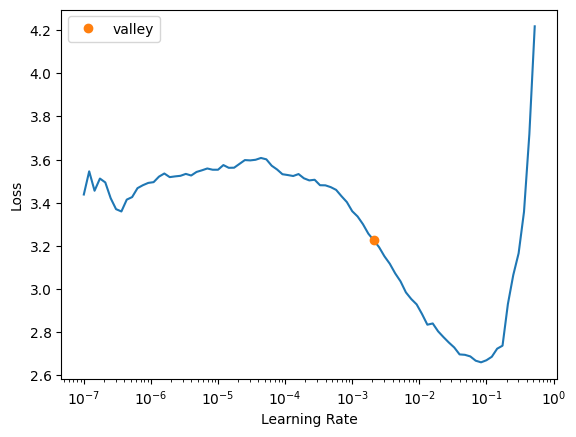

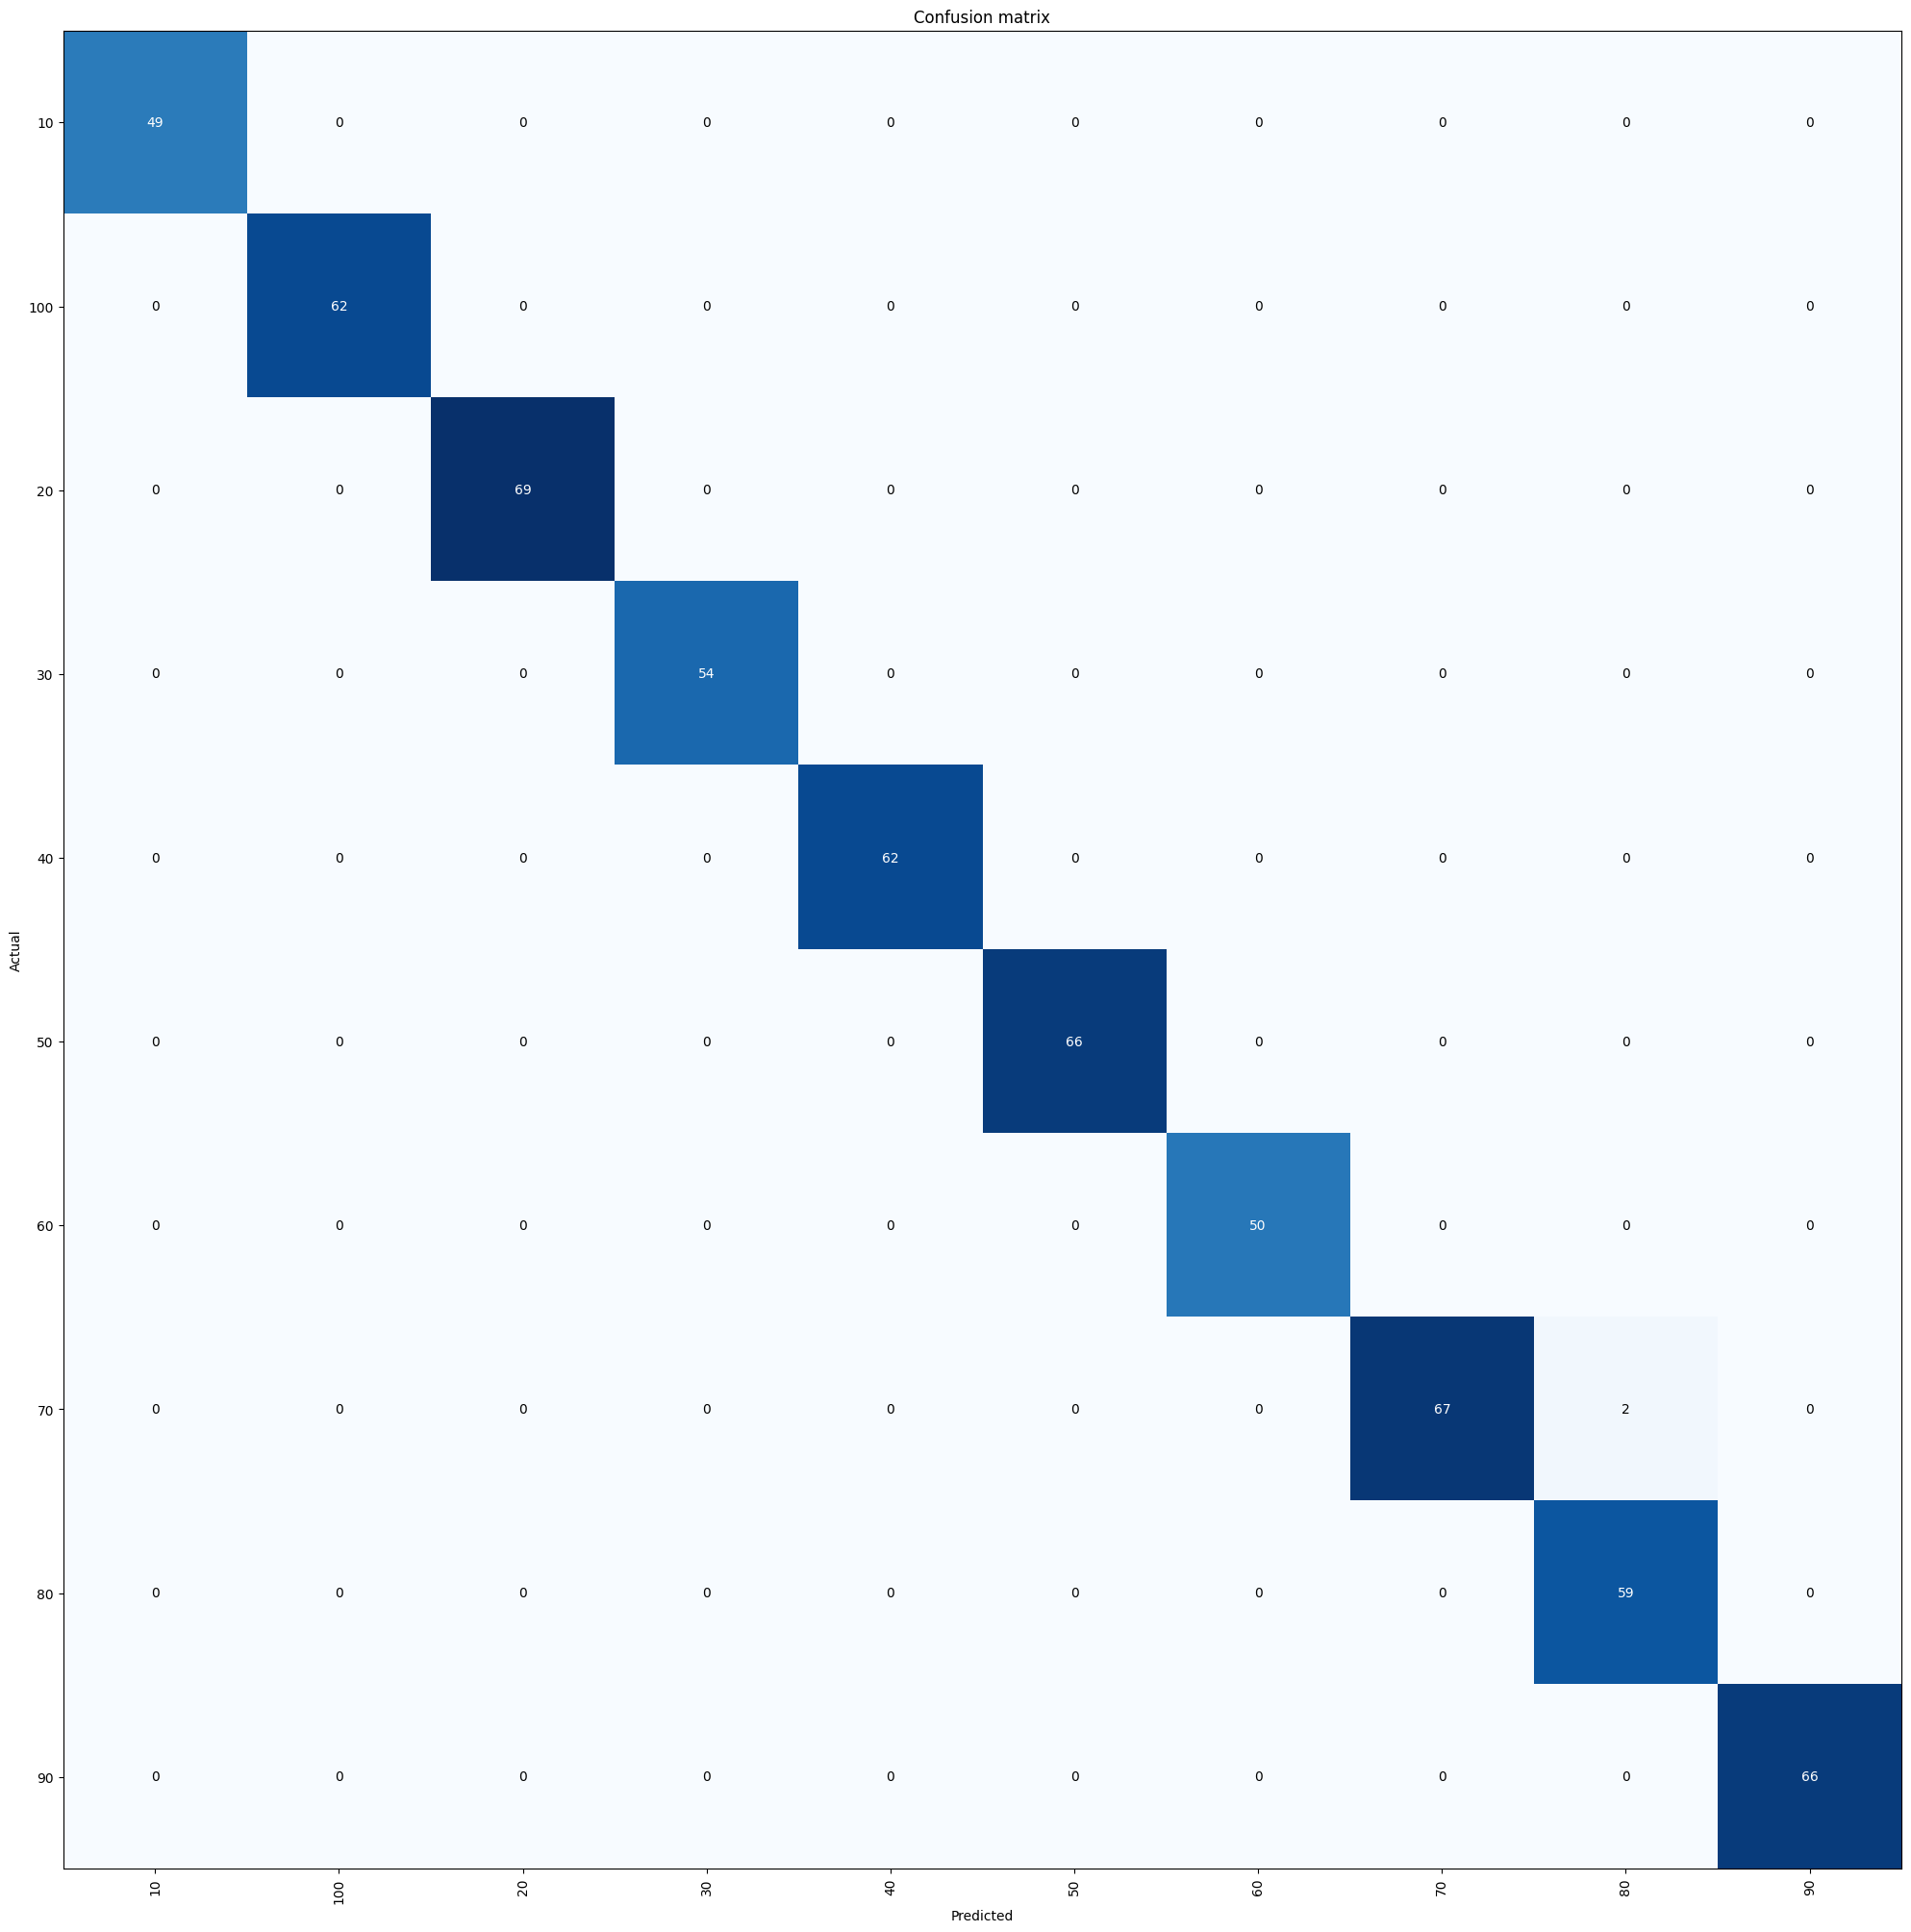

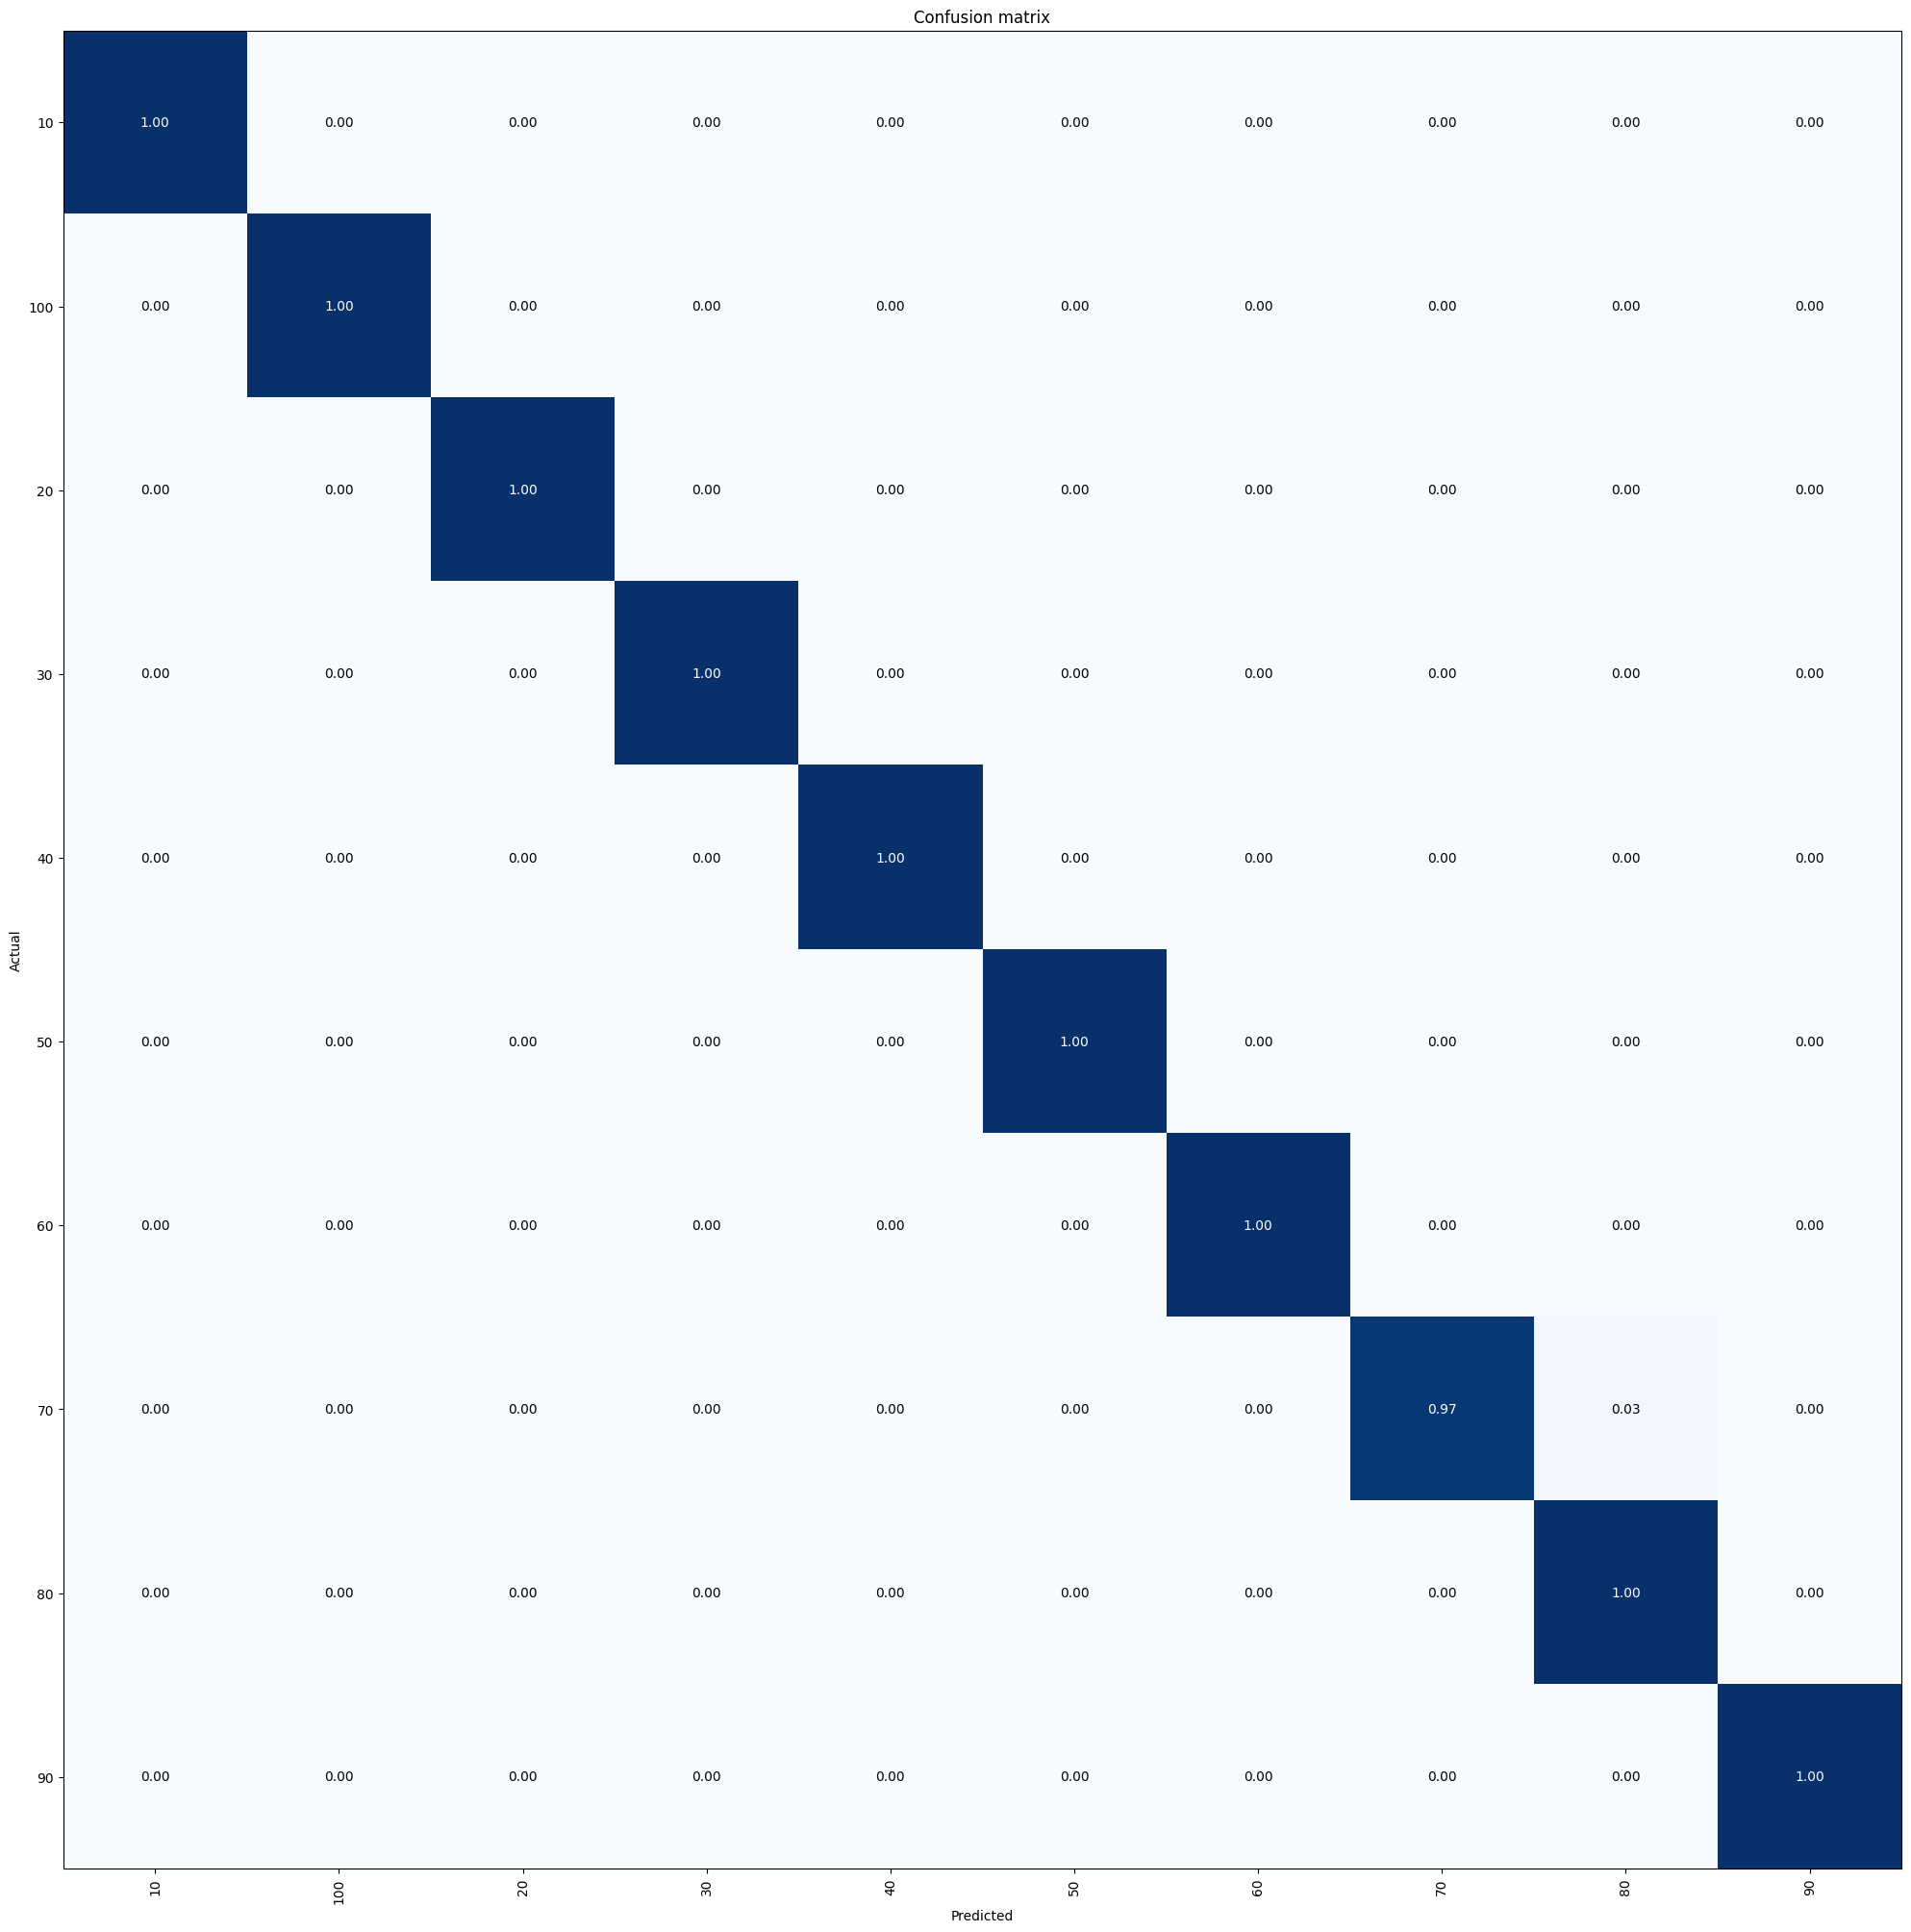

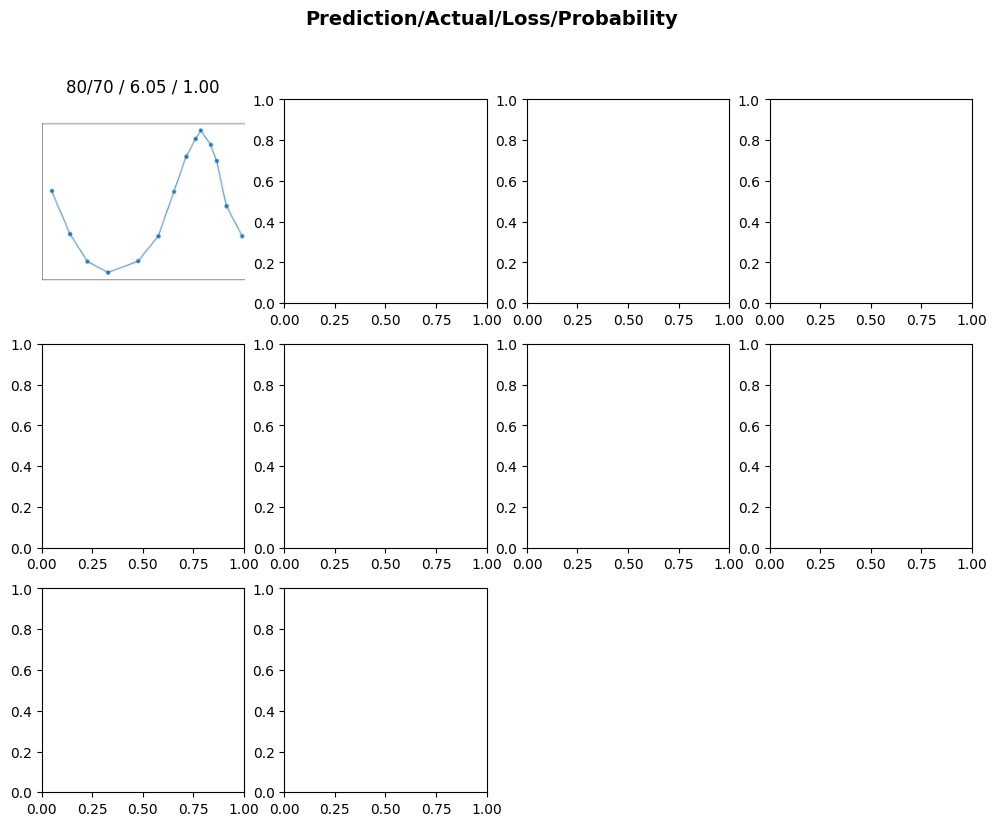

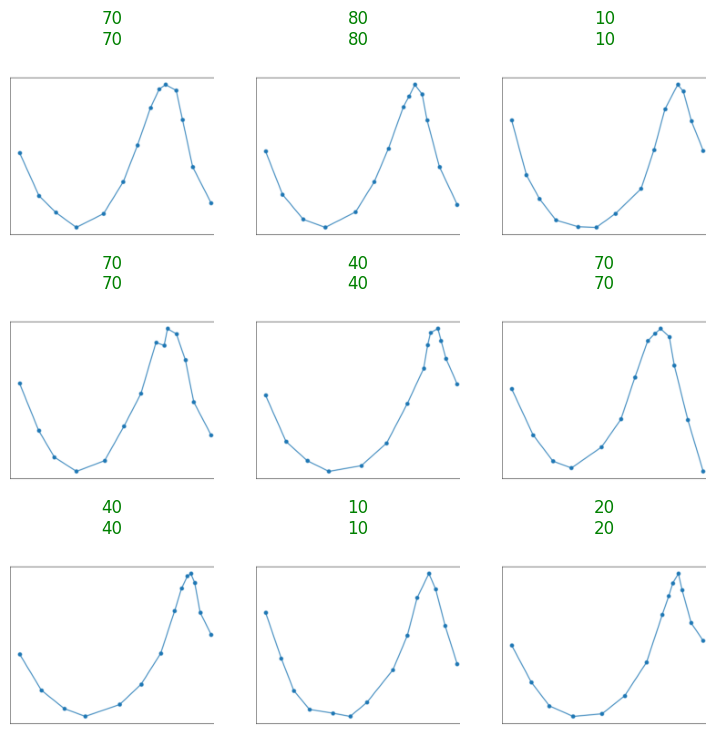

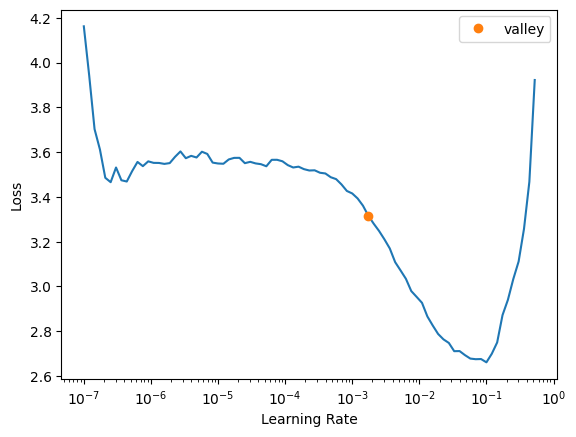

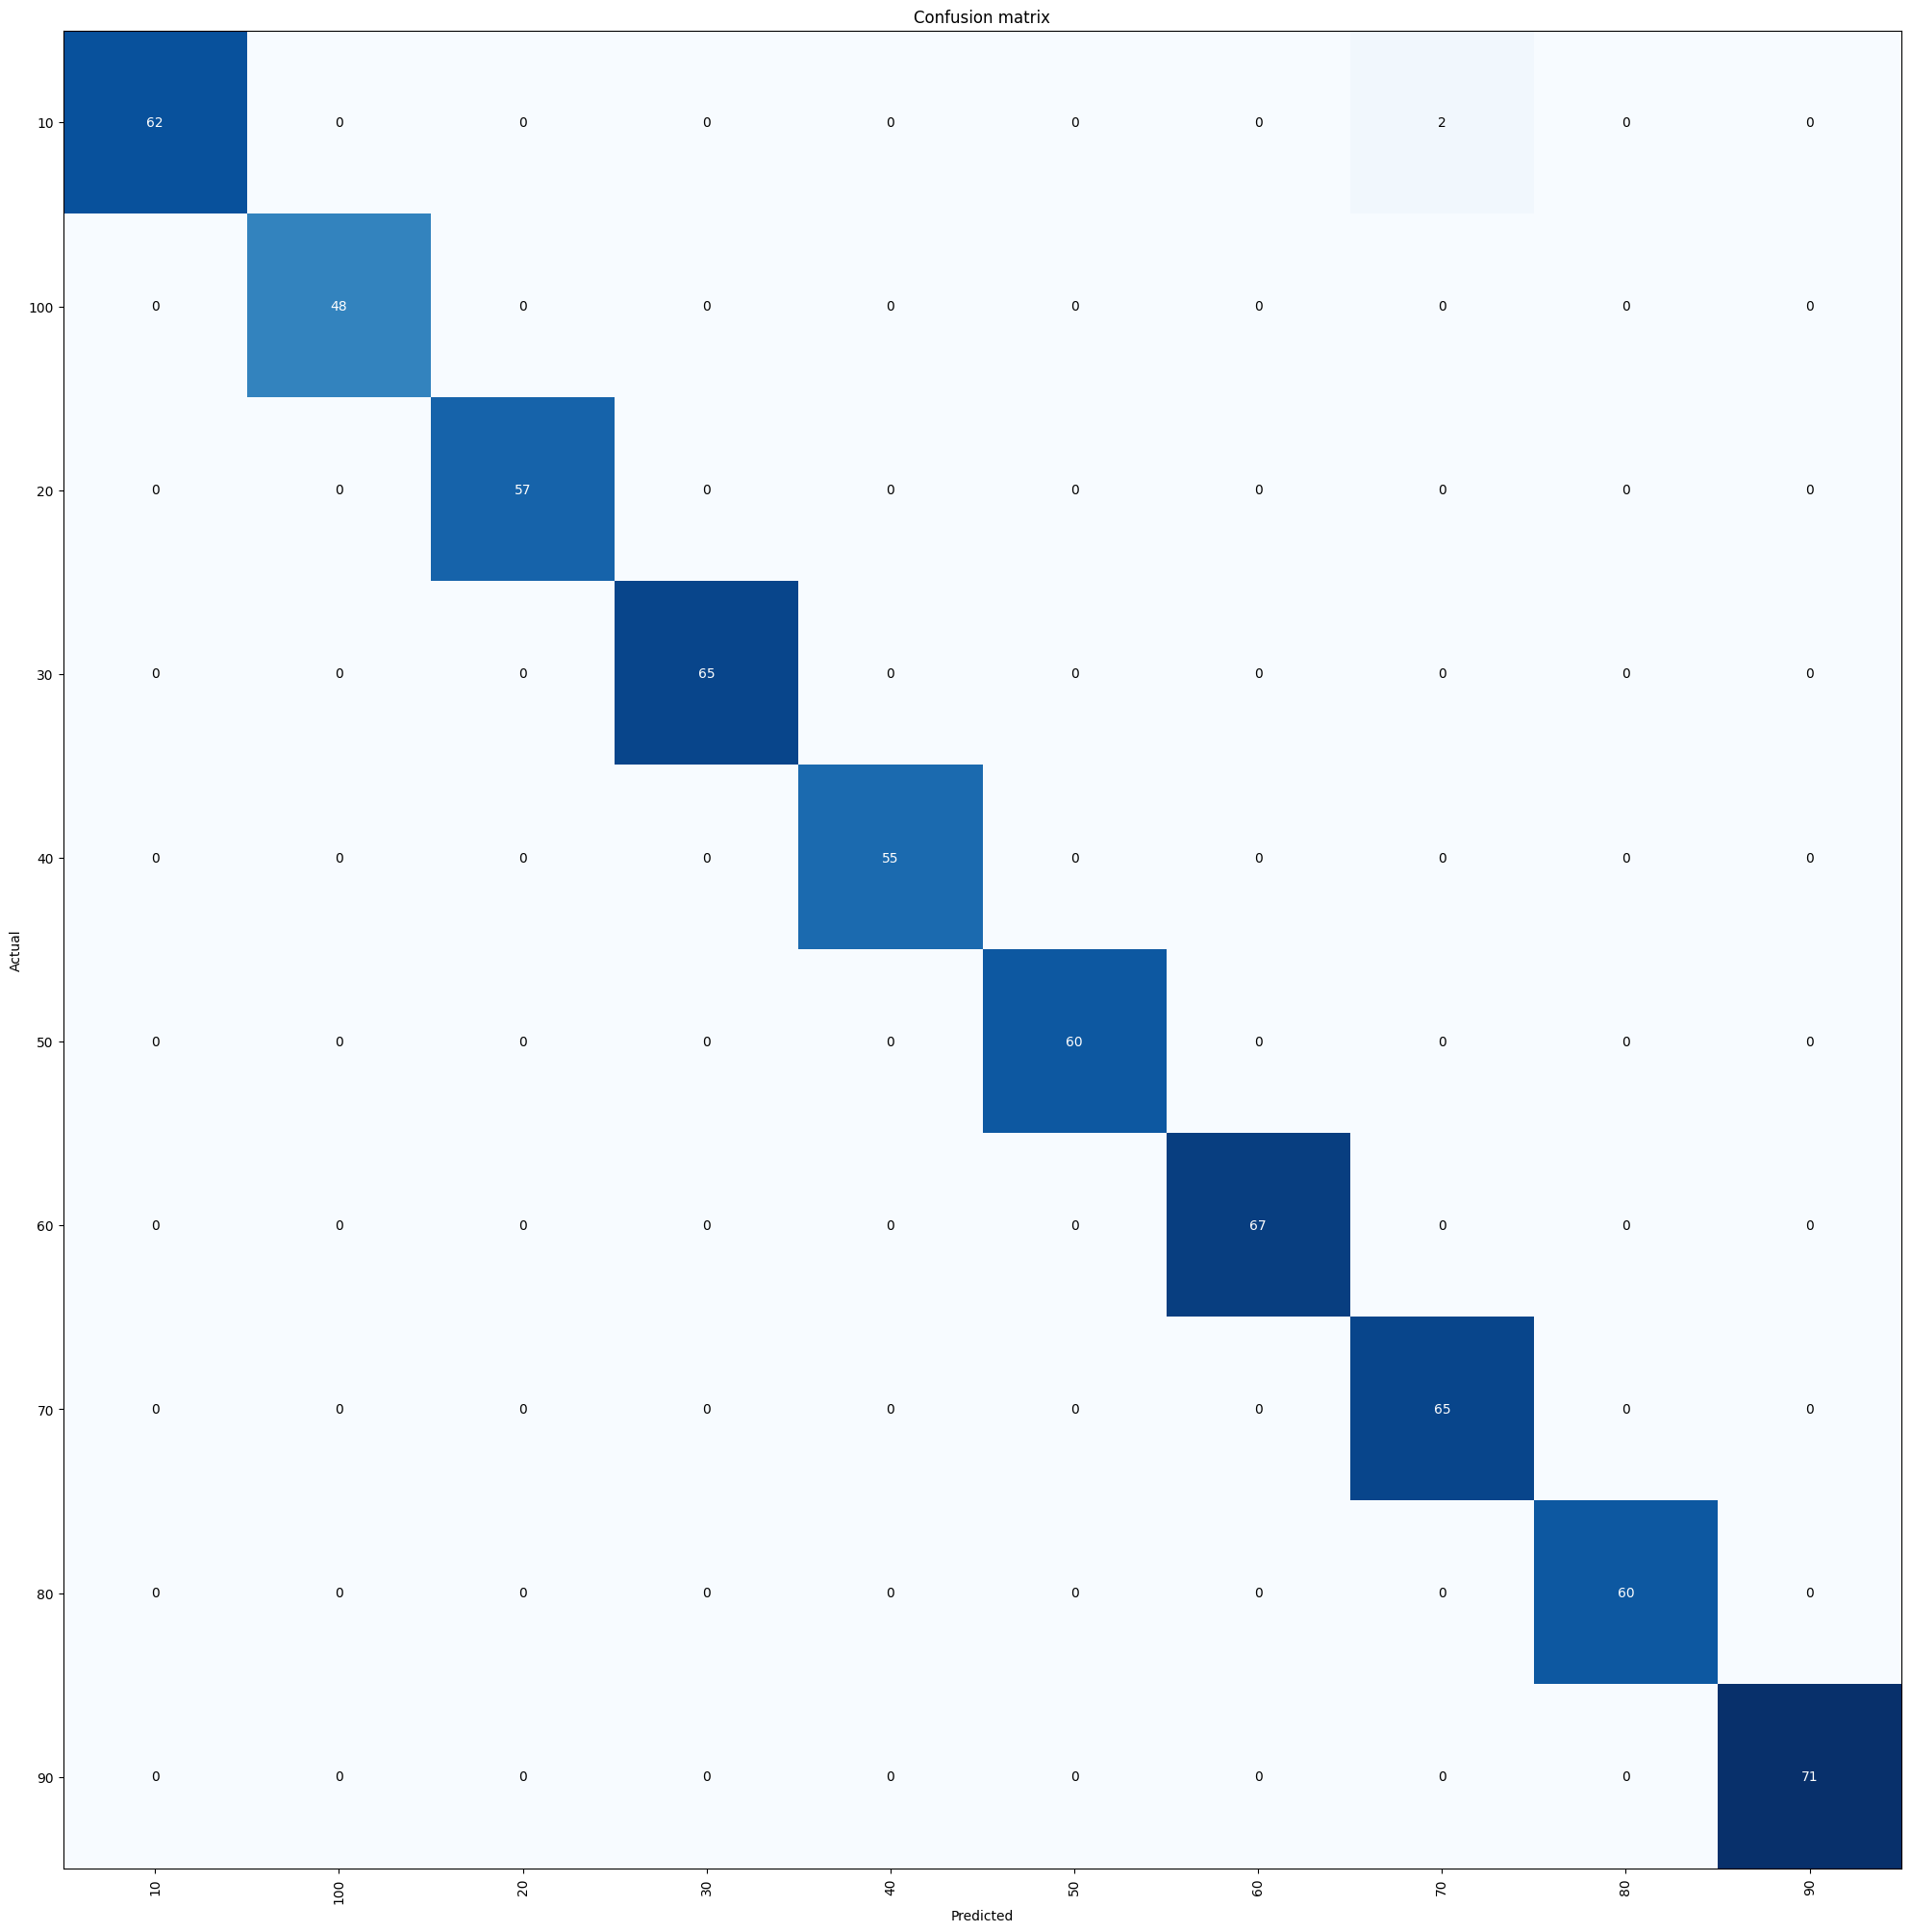

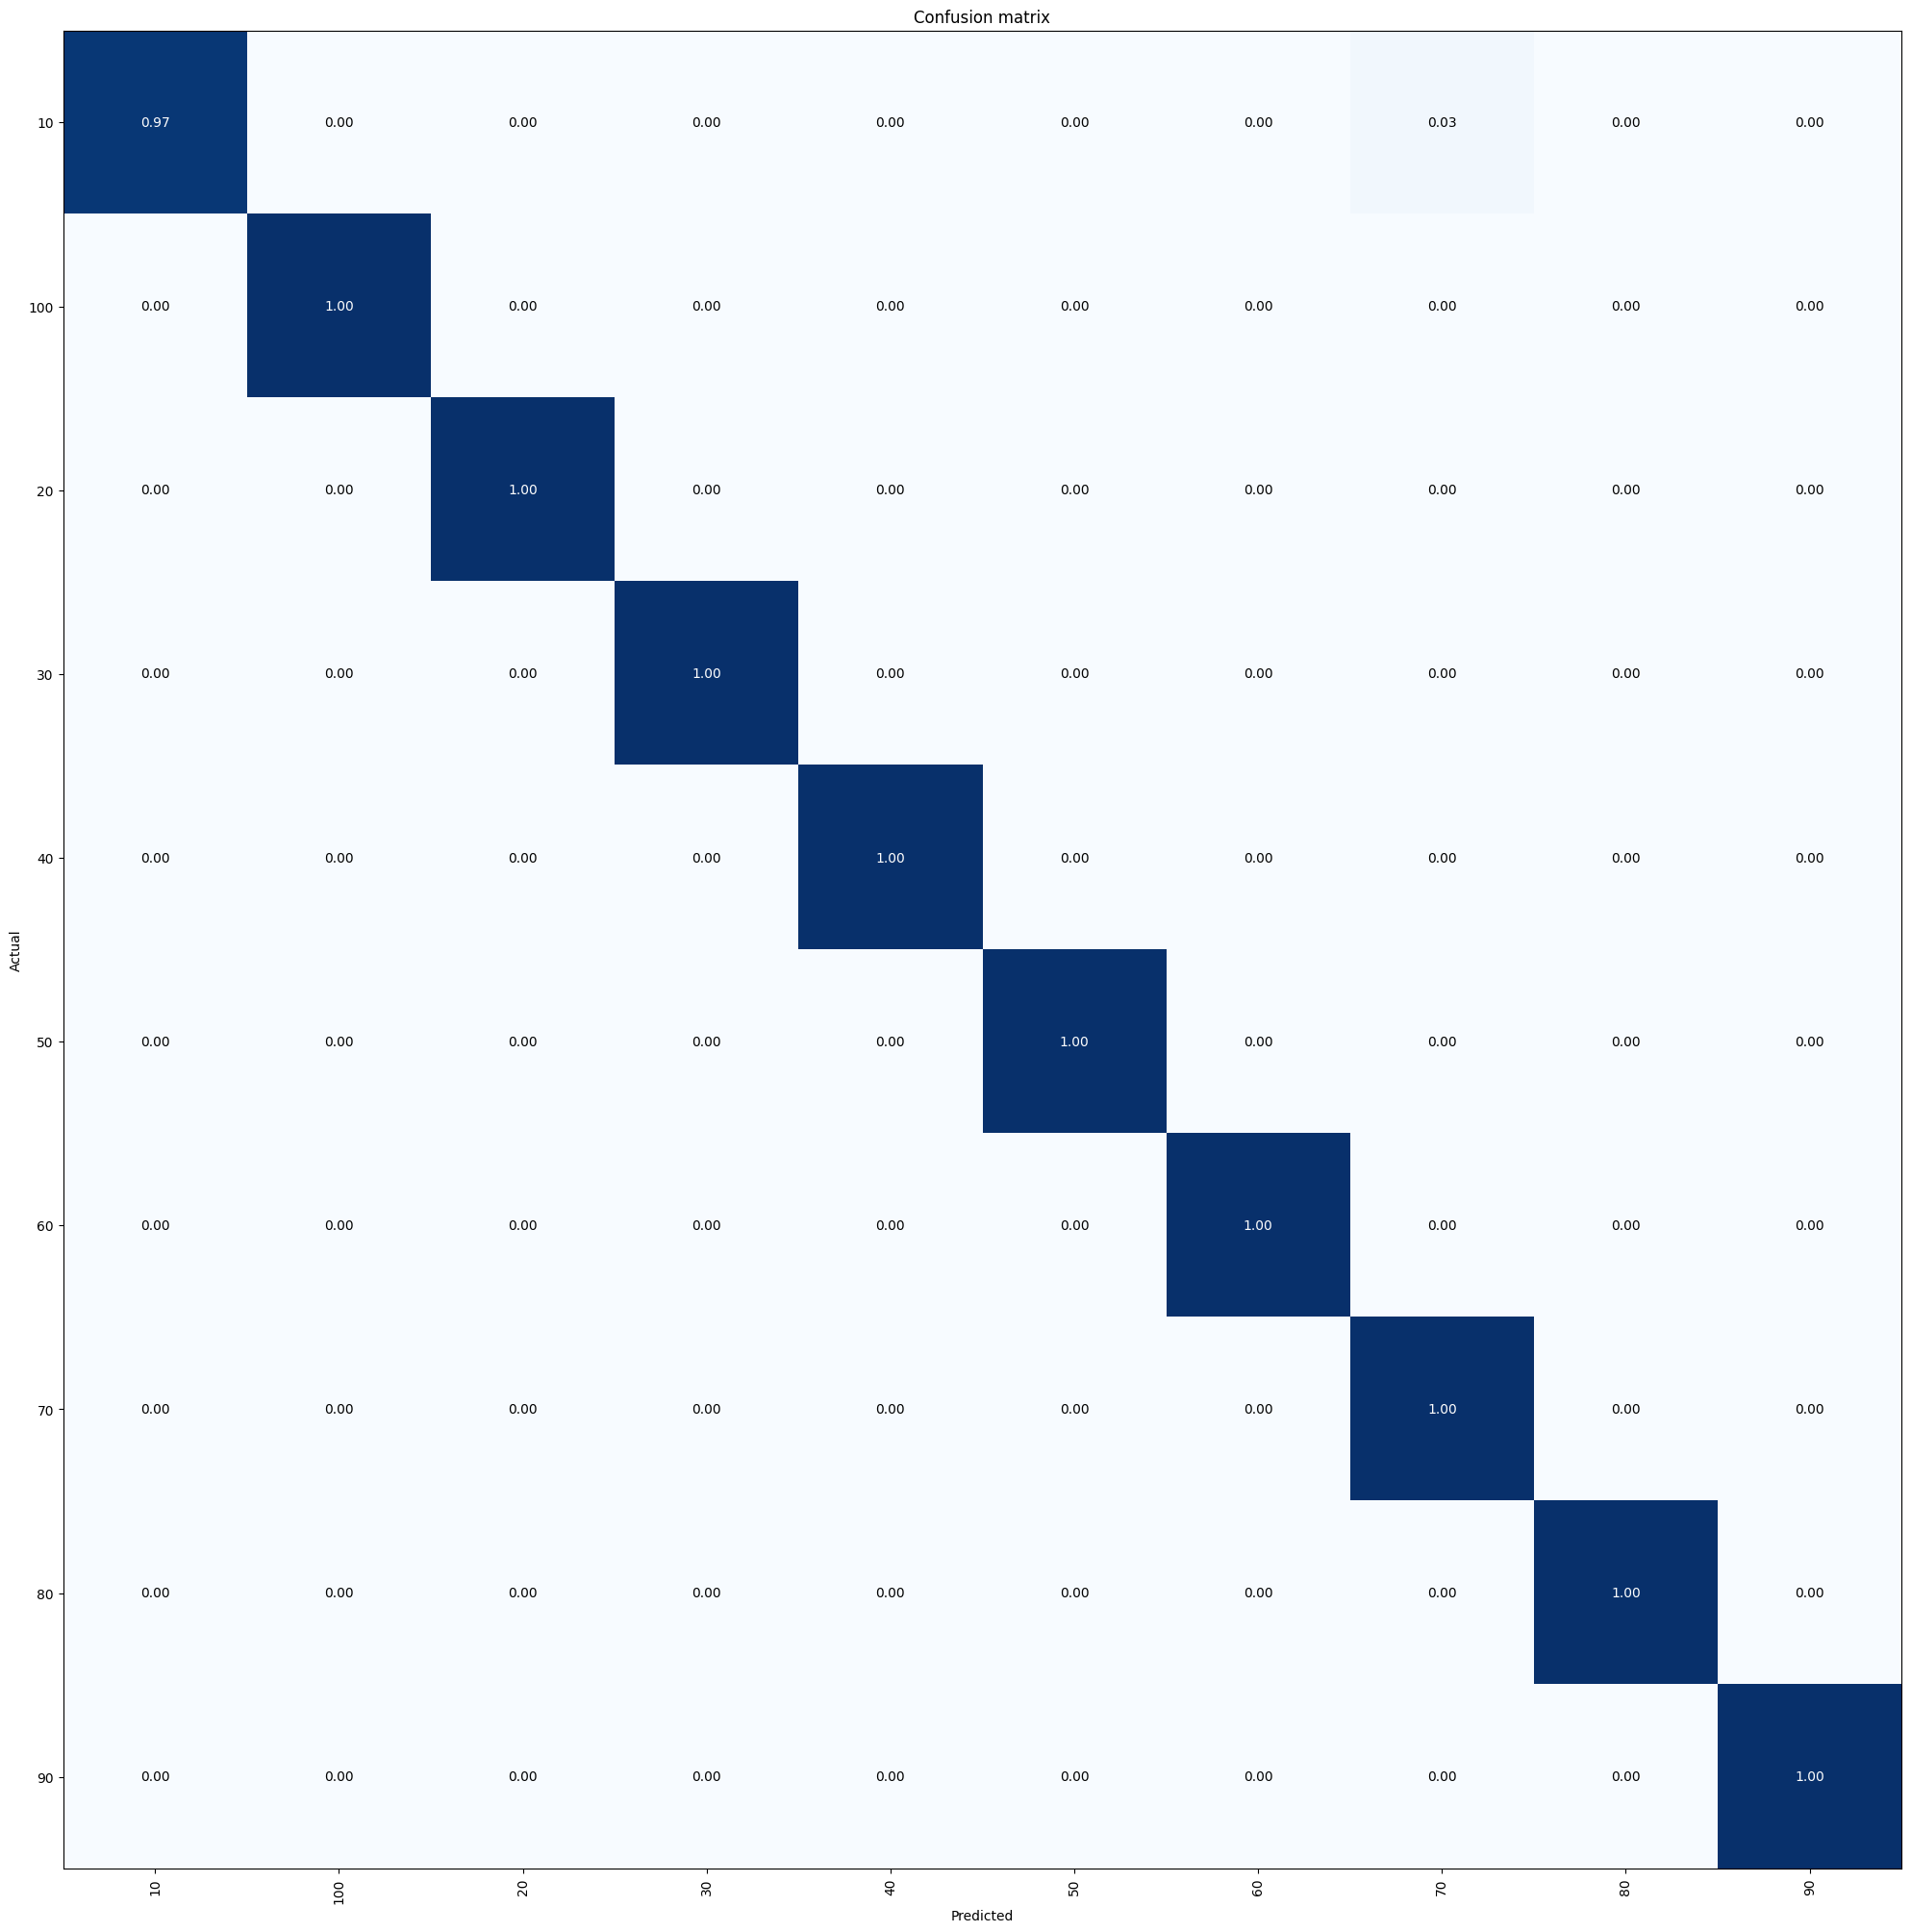

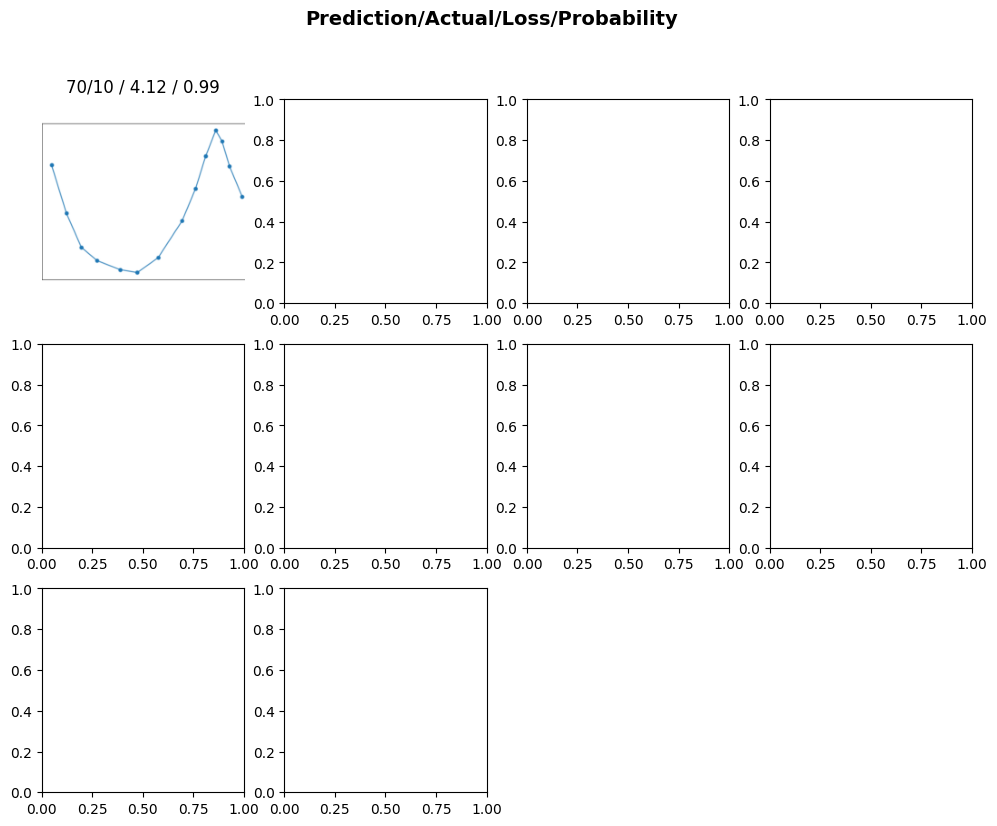

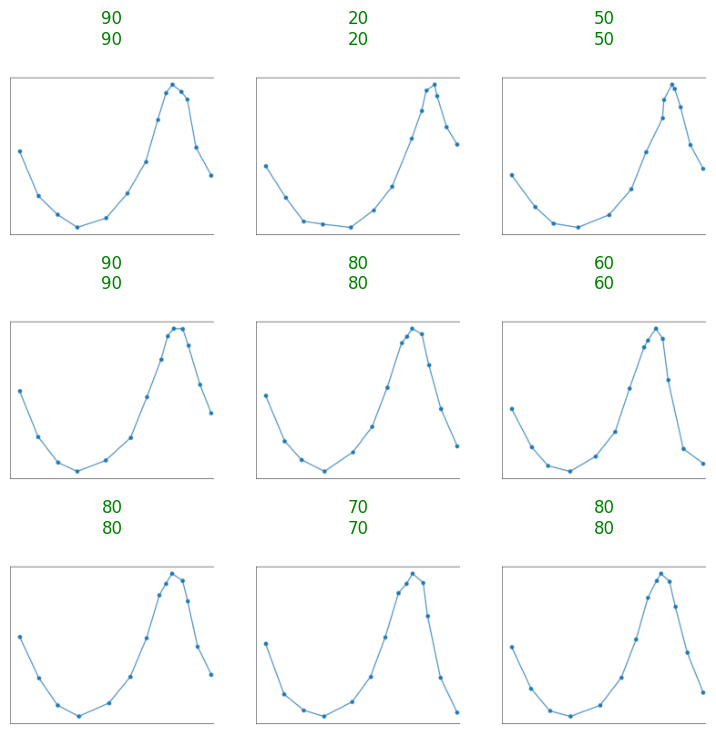

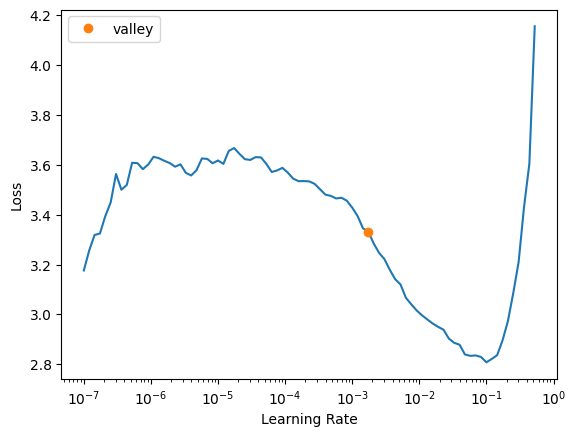

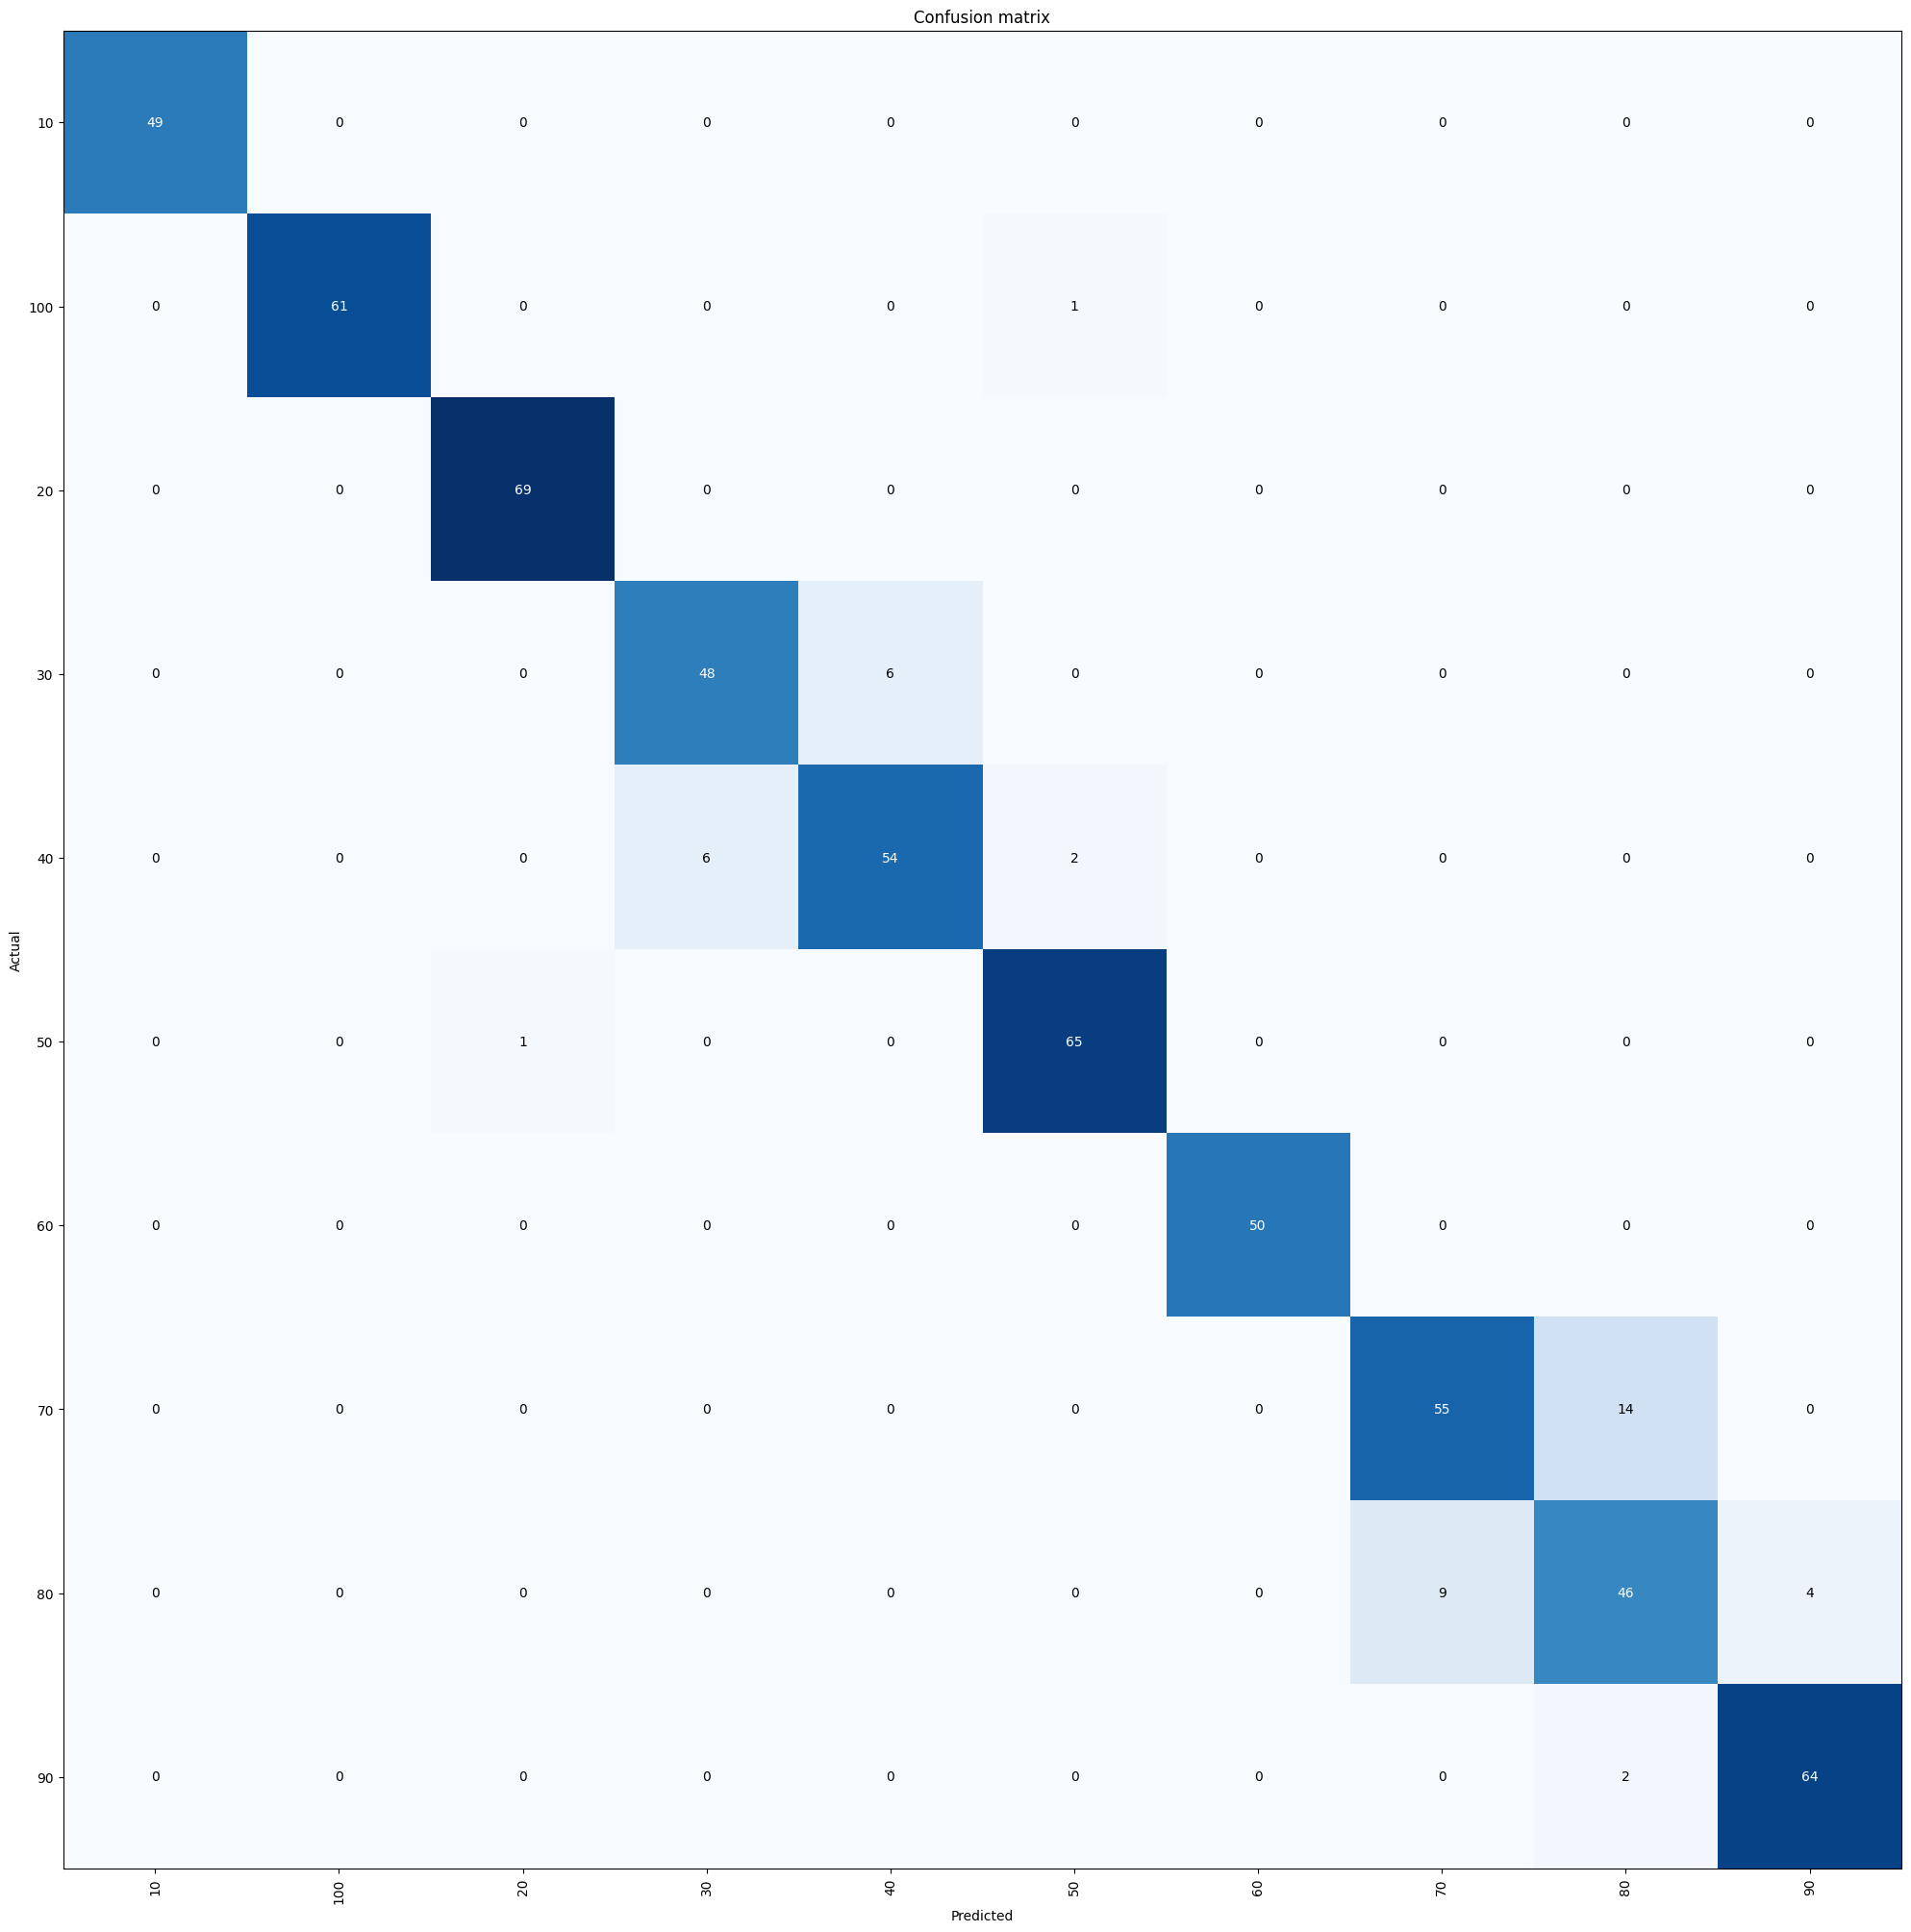

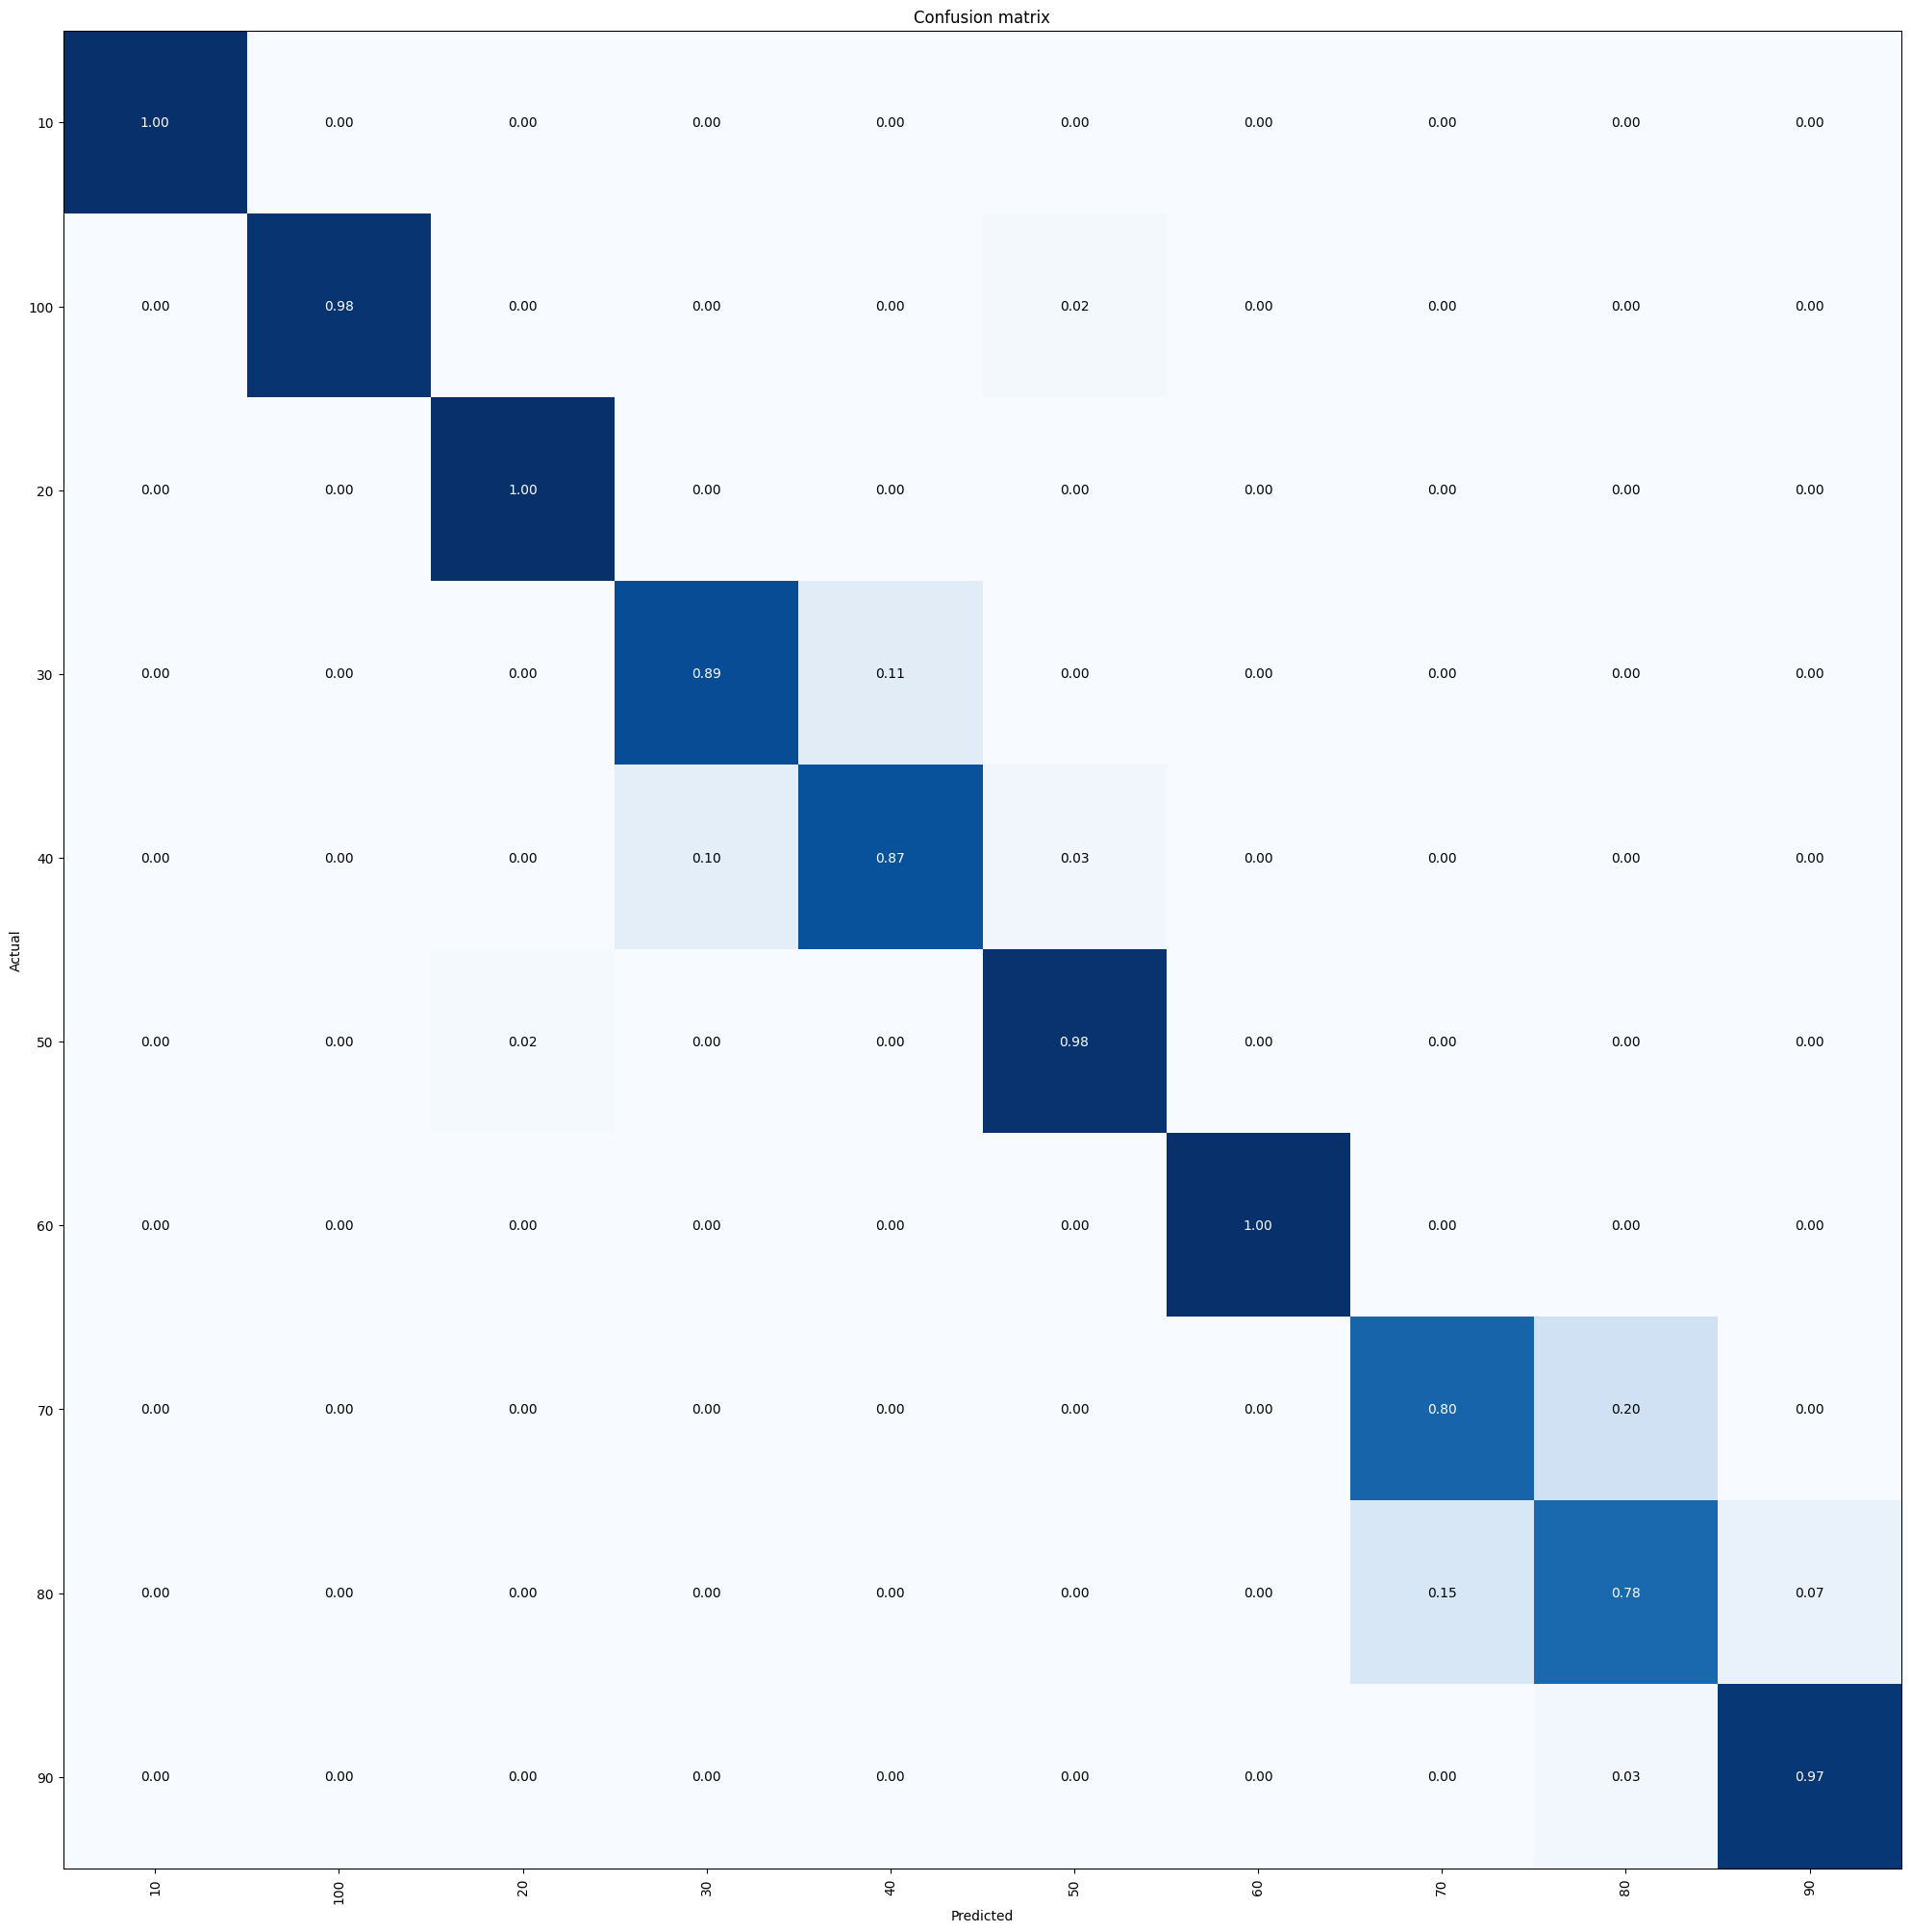

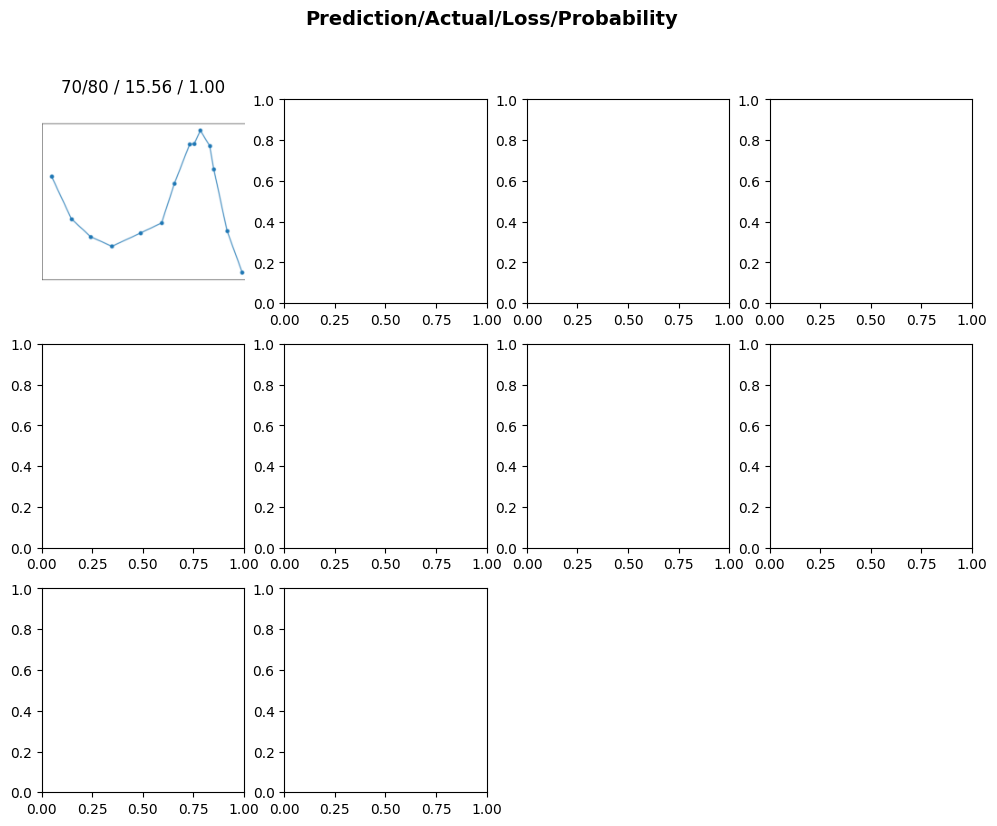

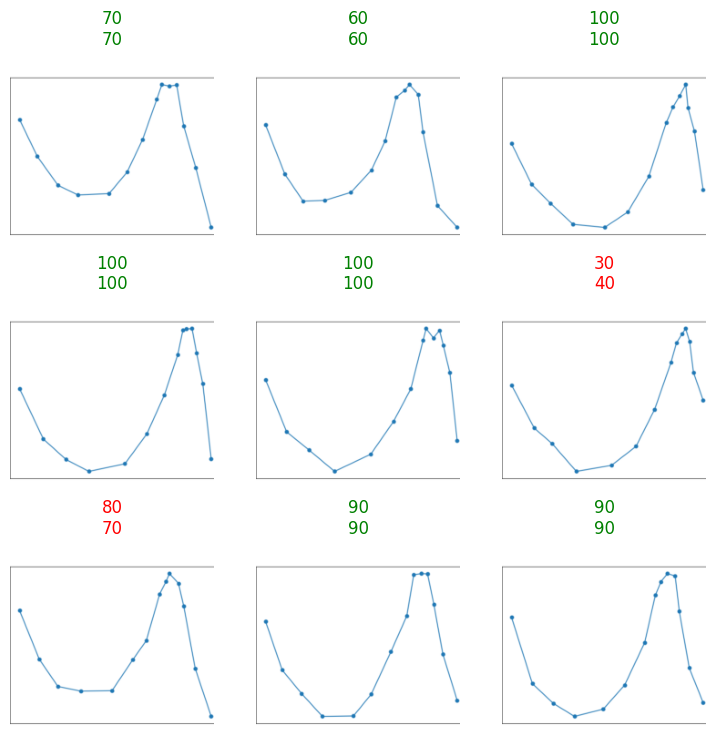

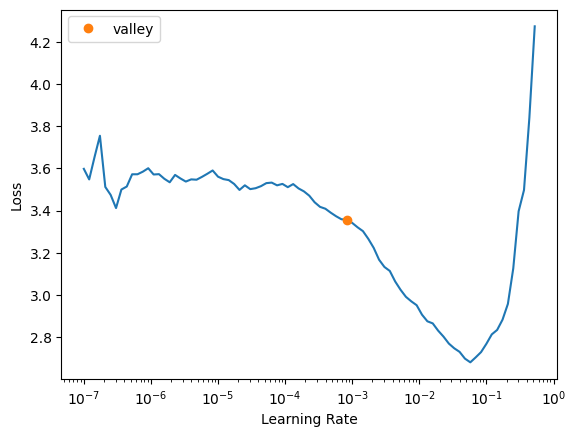

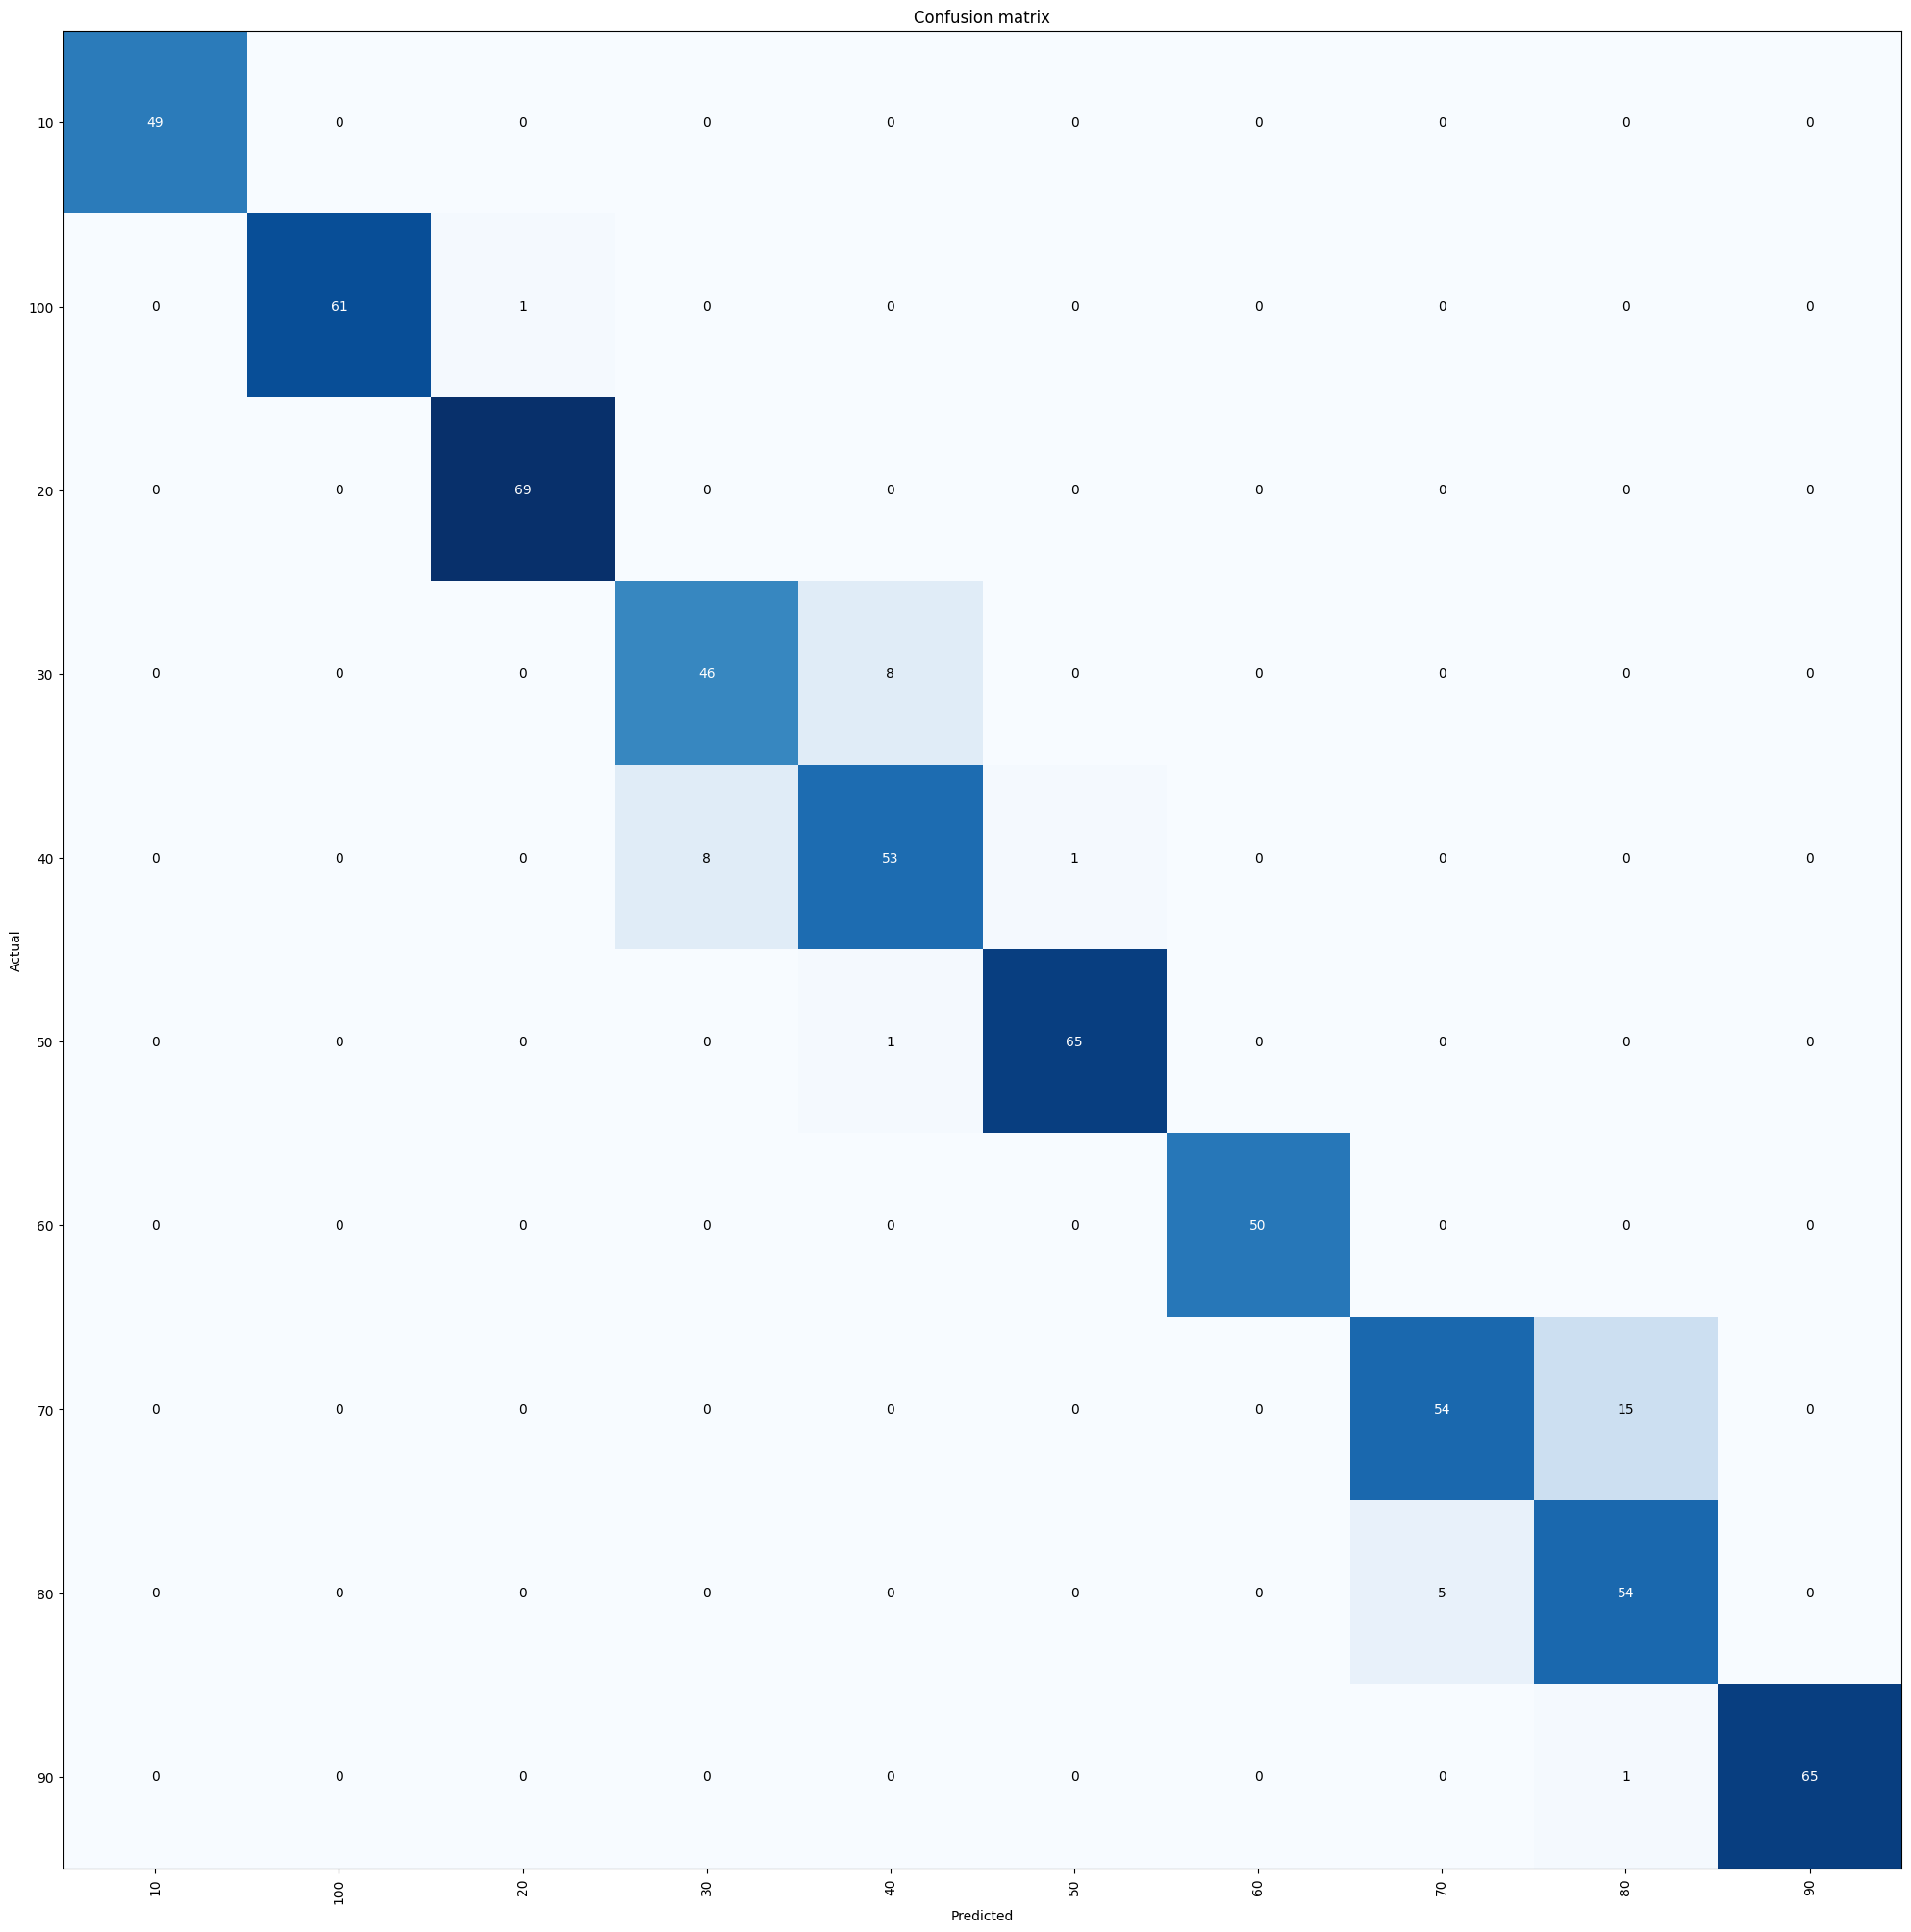

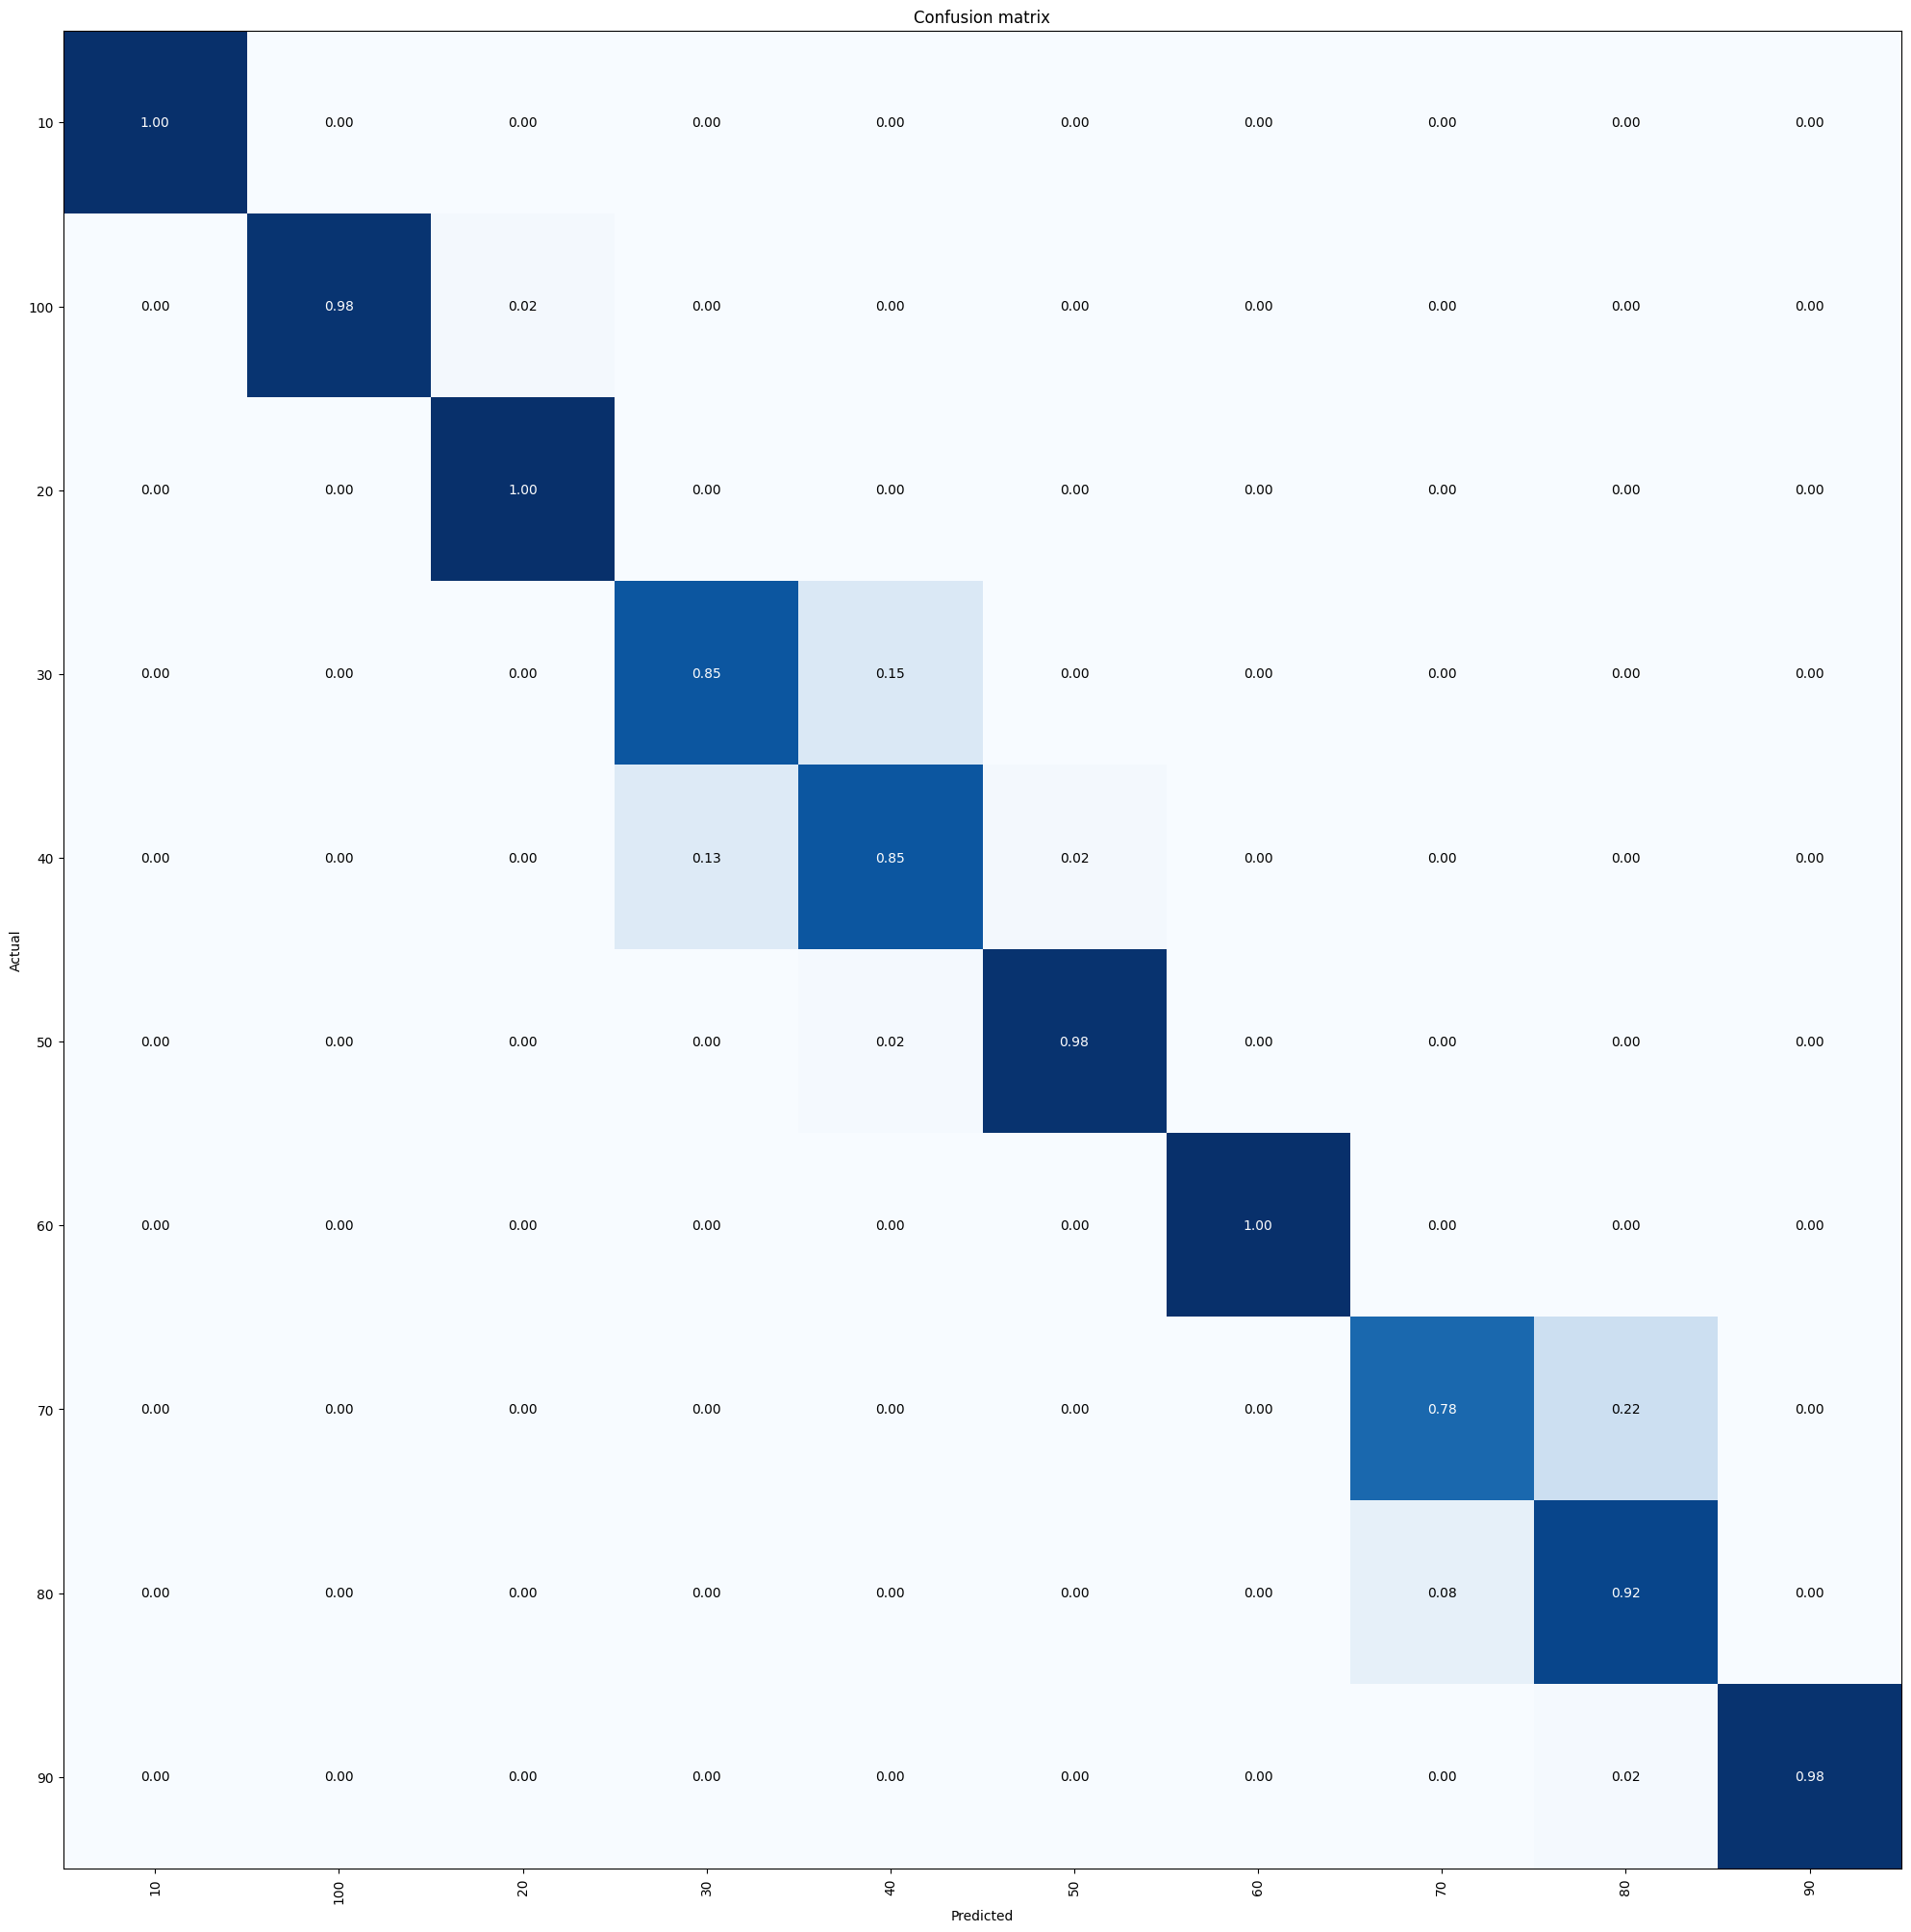

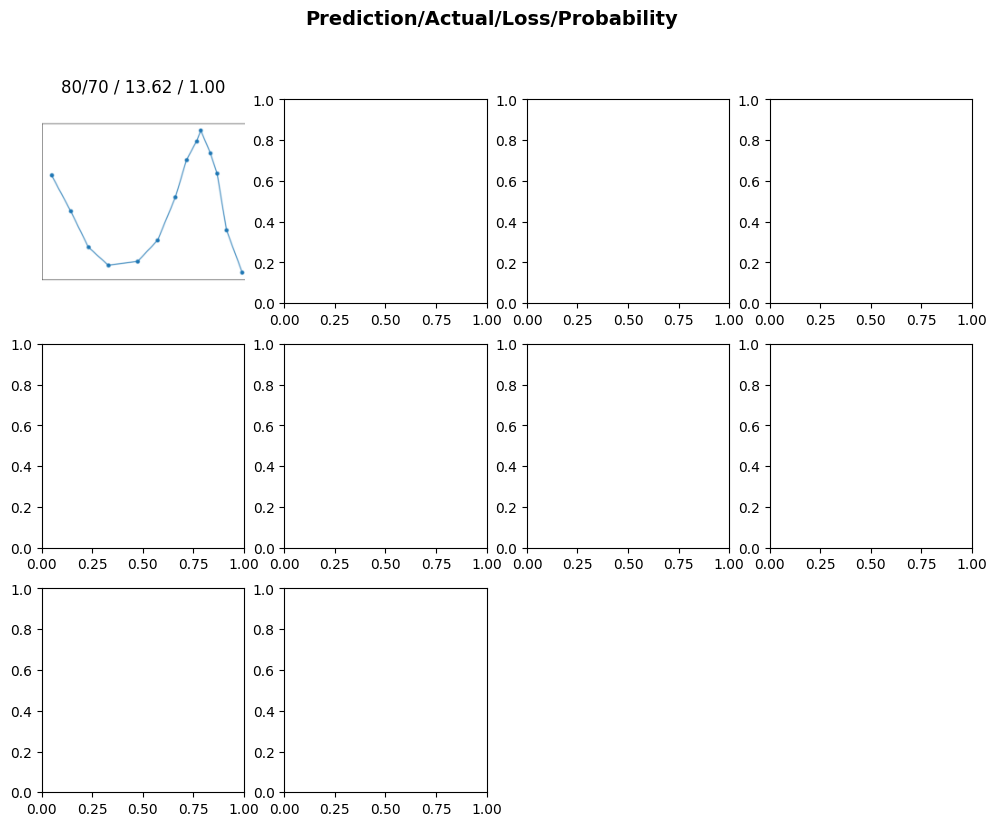

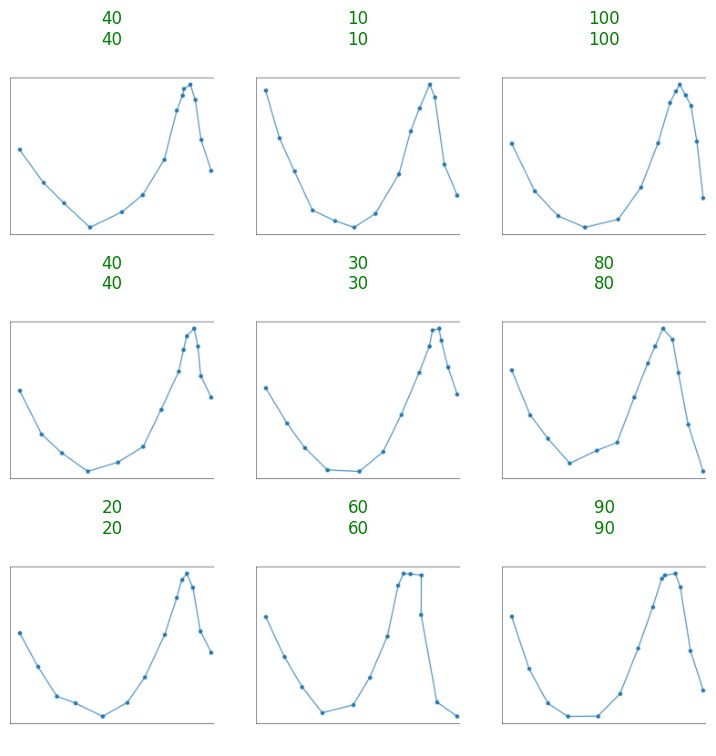

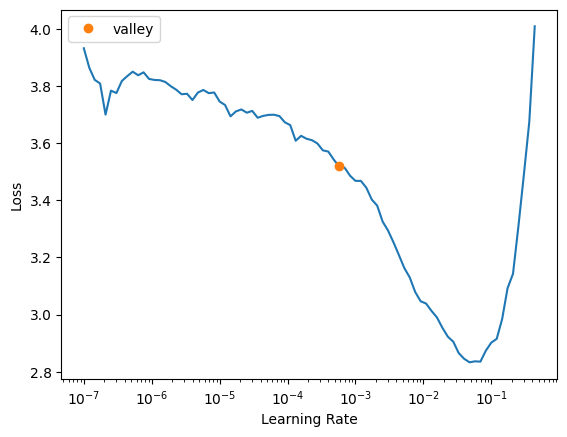

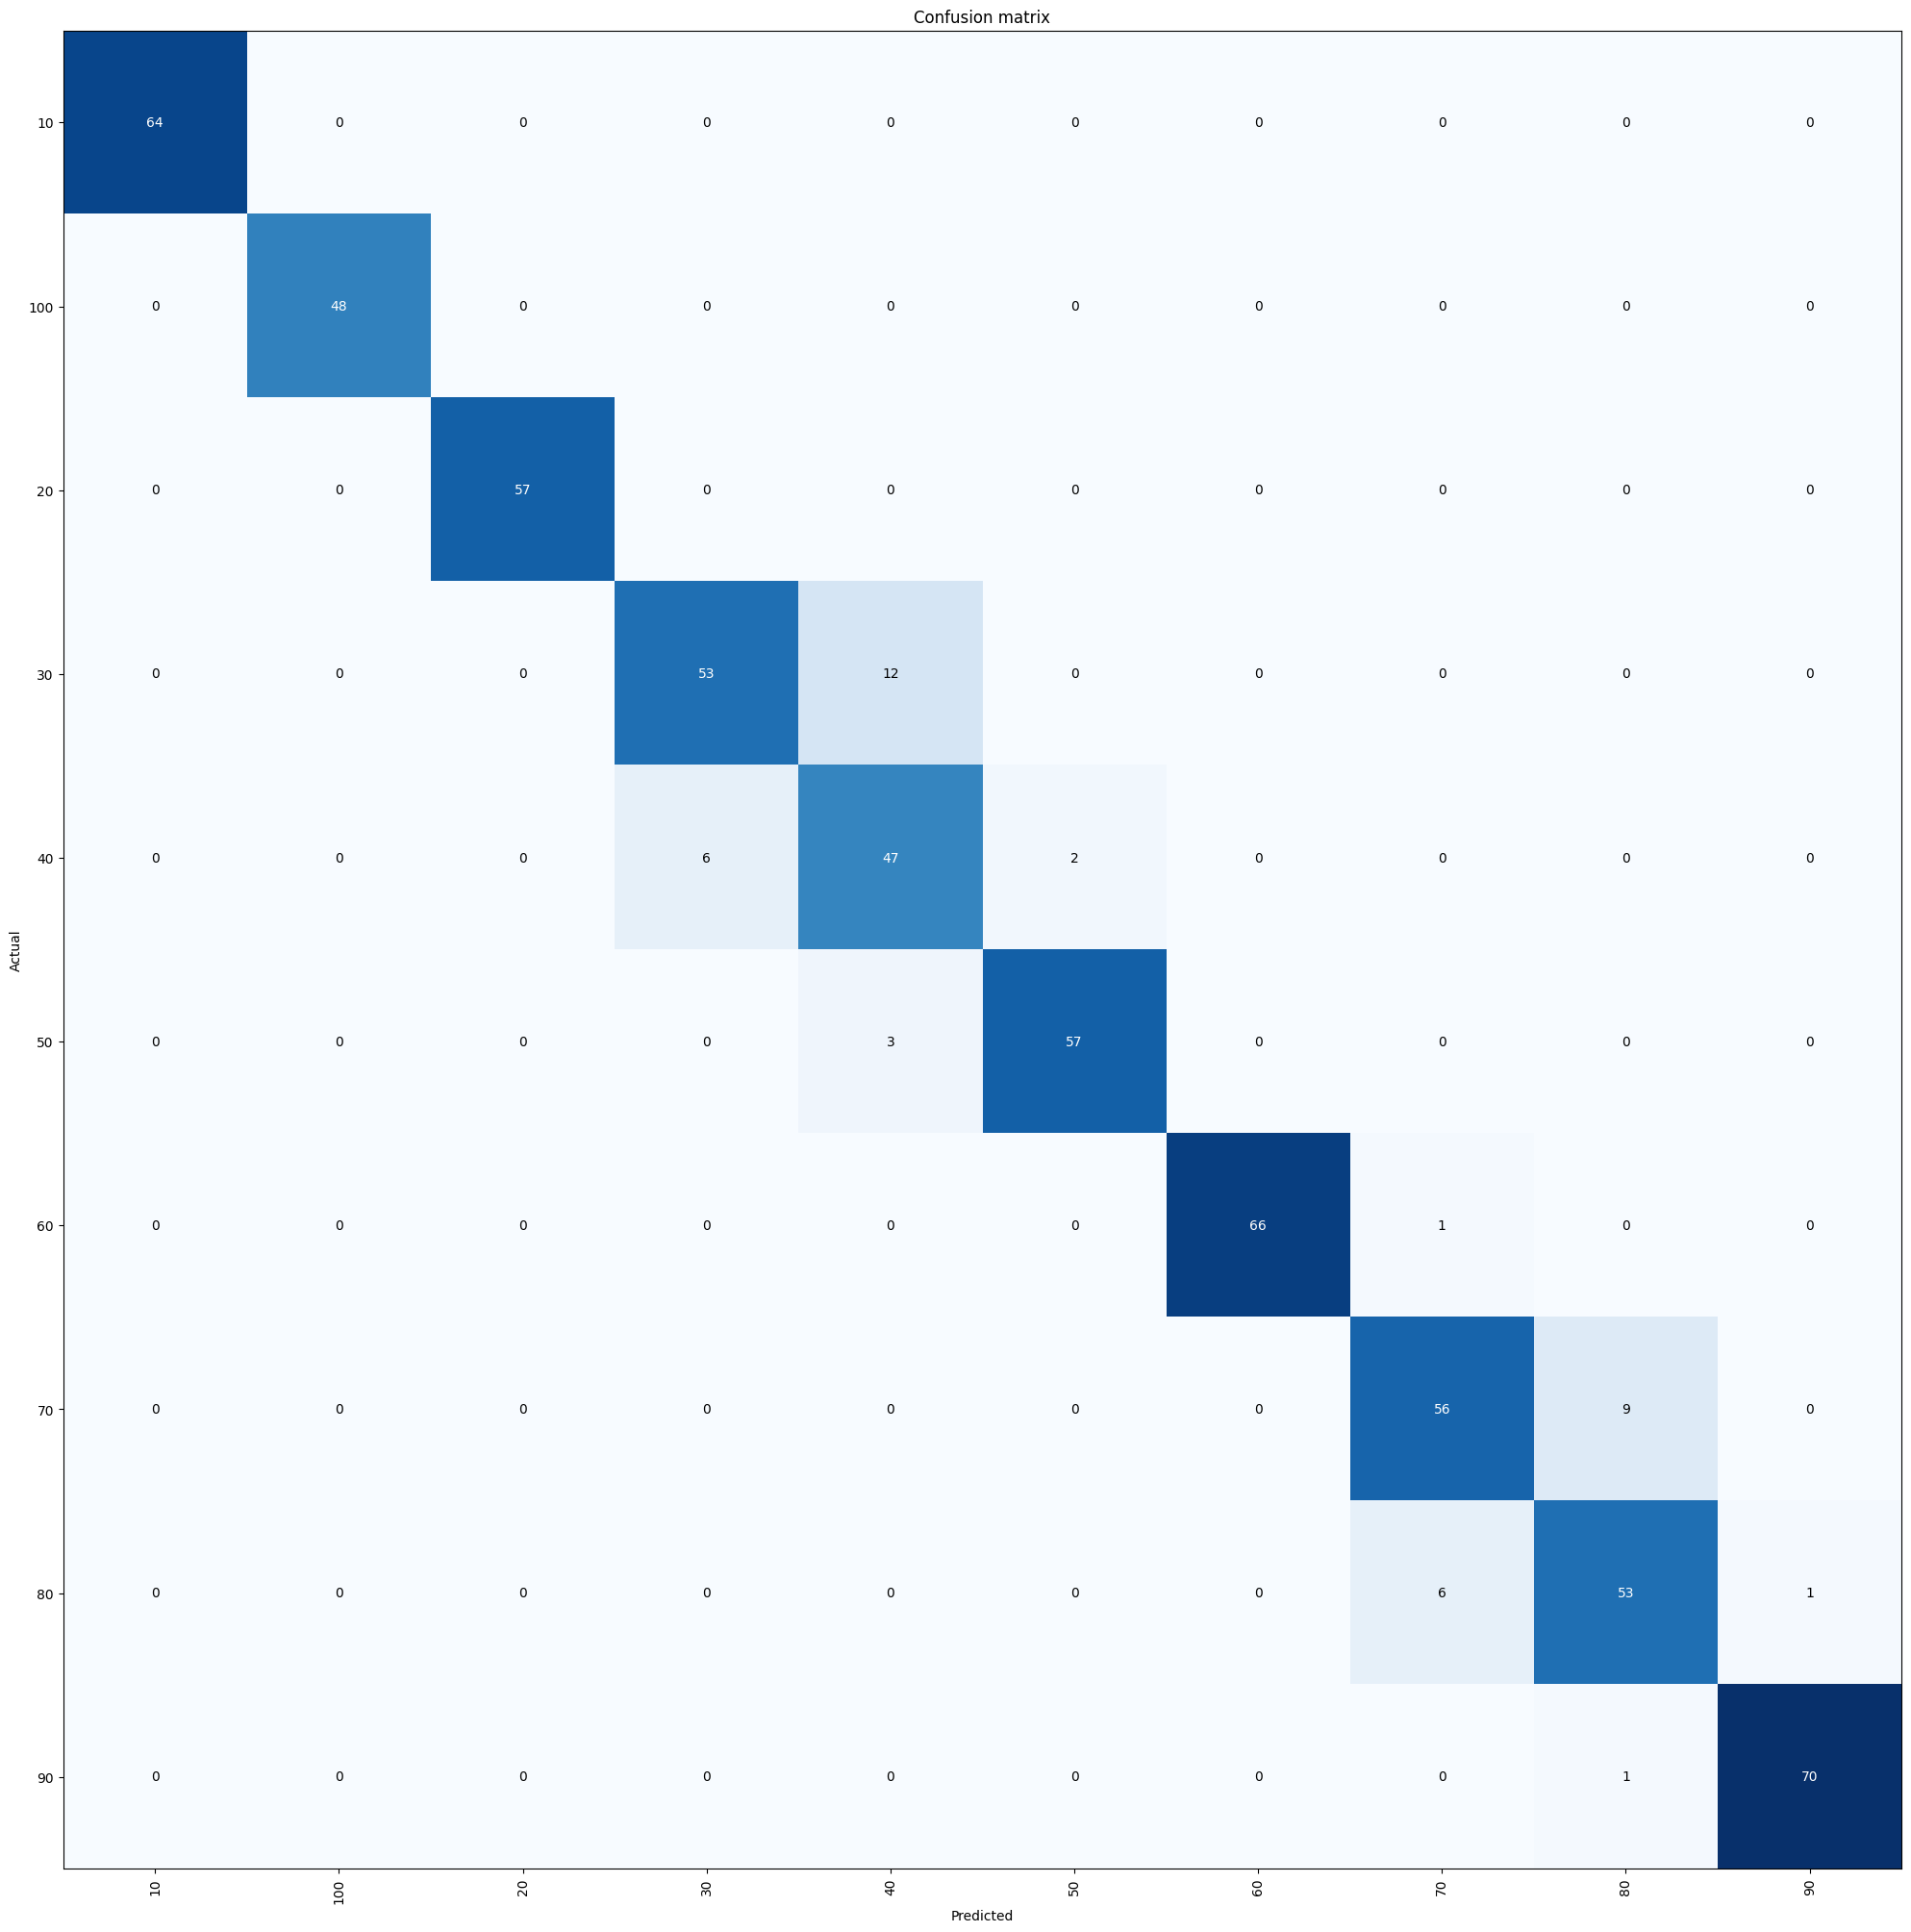

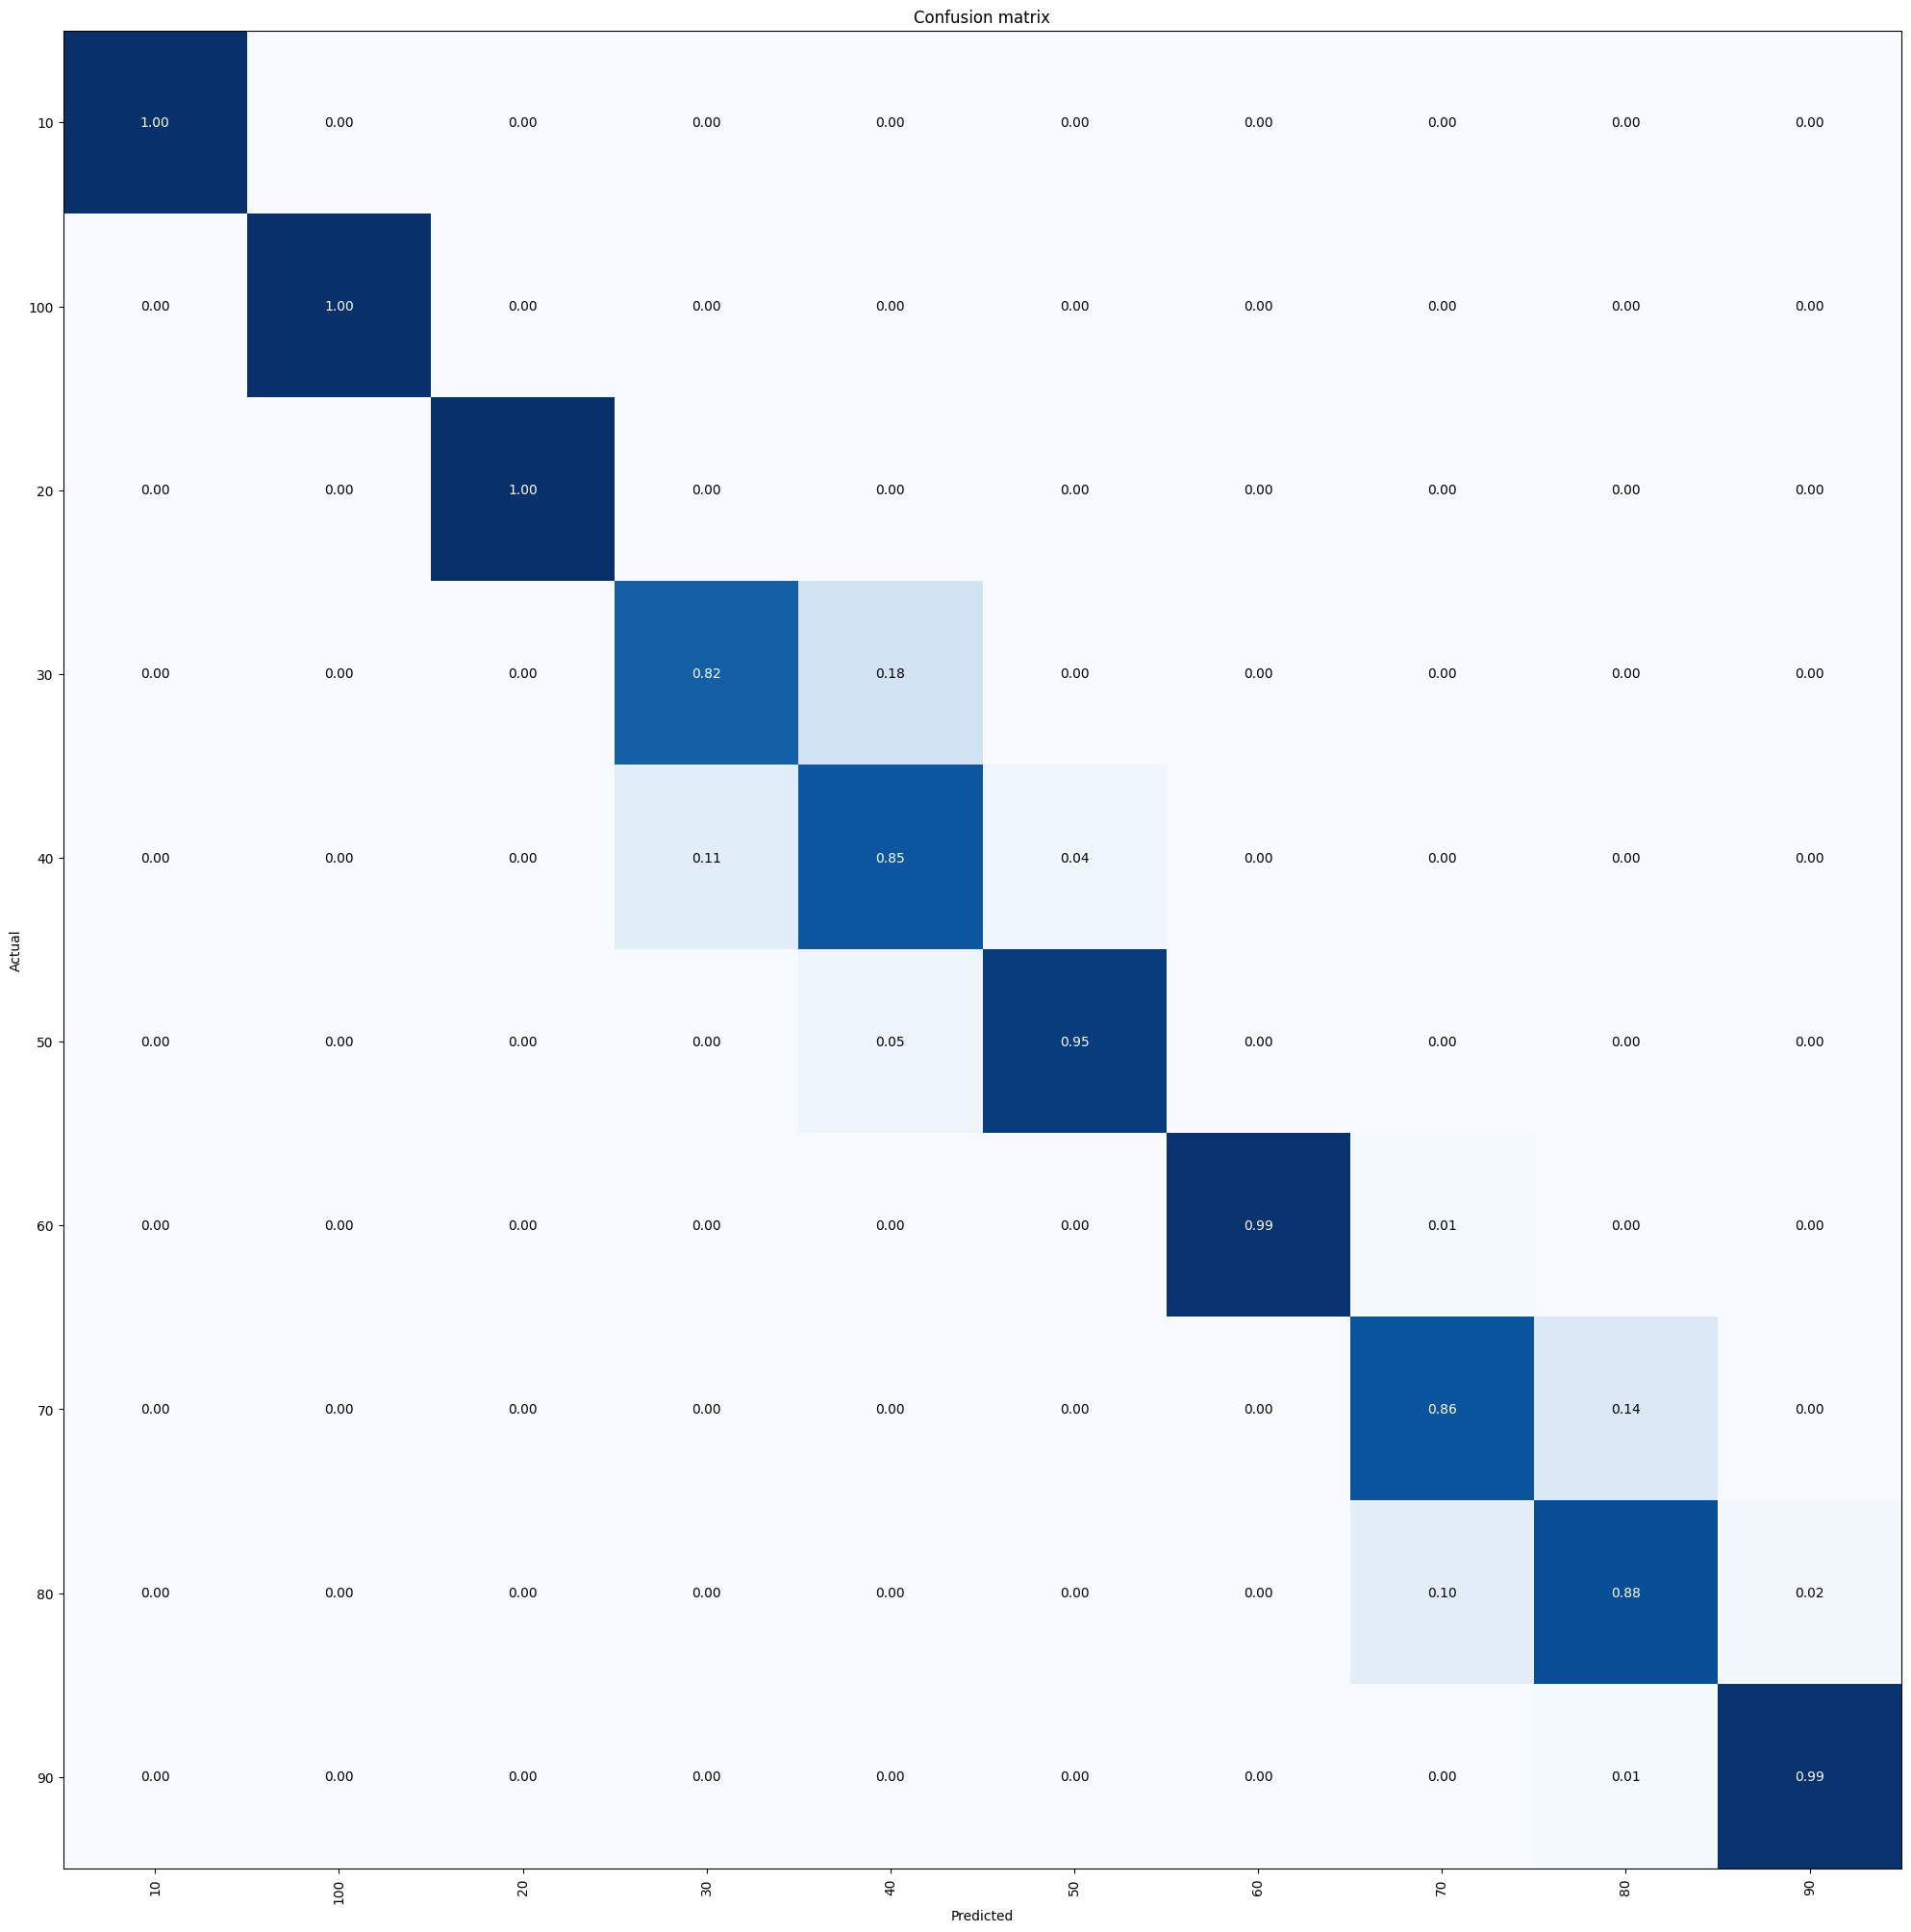

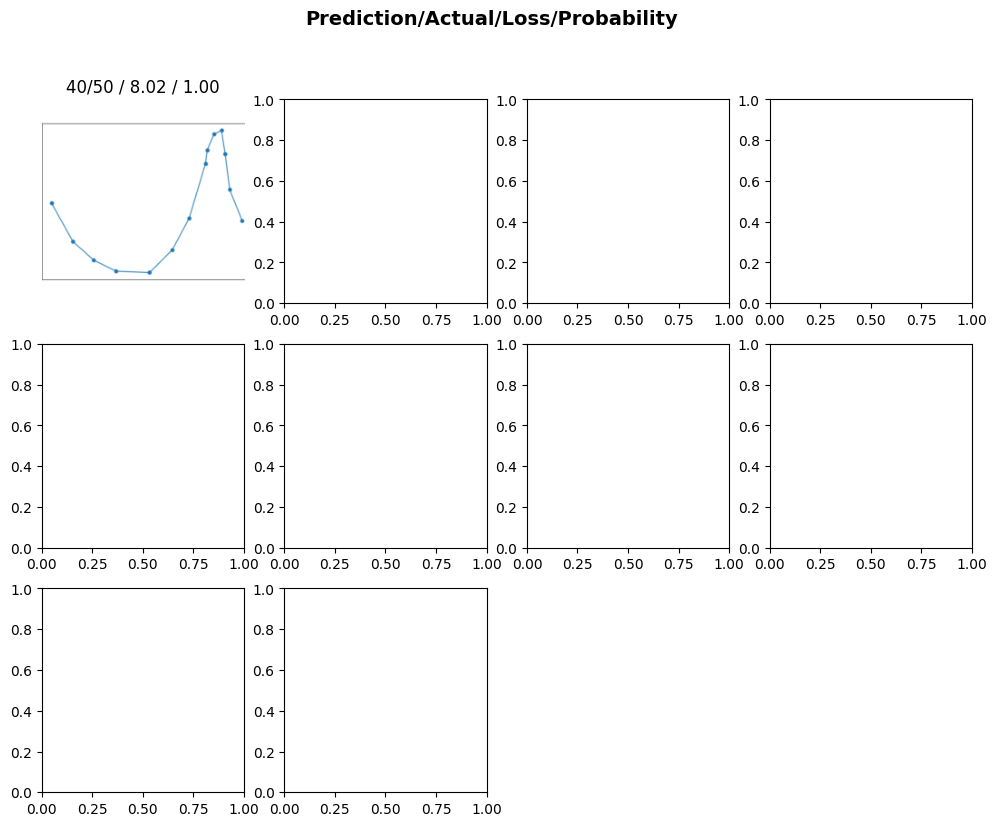

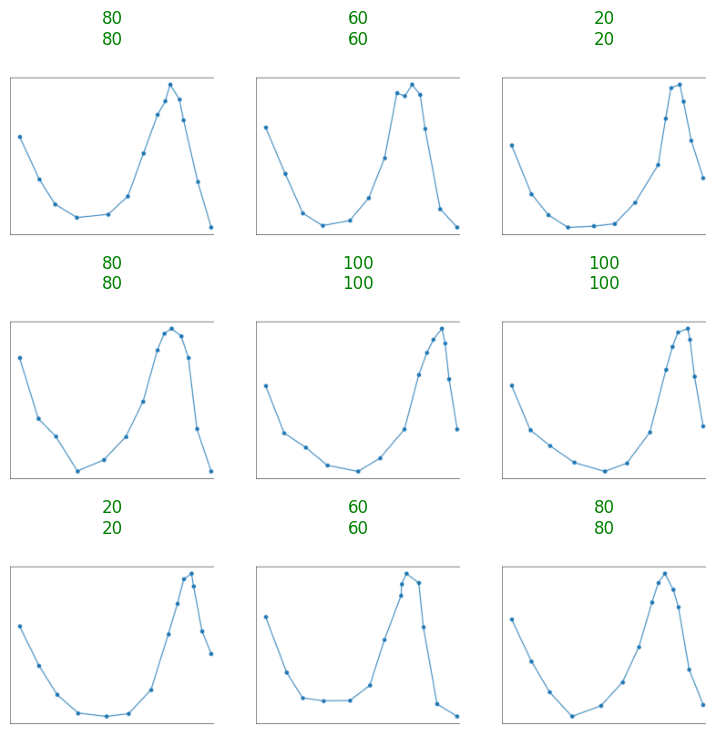

In [17]:
cross_validation_list = config['cross_validation_list']
cross_validation_experiment_names = config['cross_validation_experiment_names']
all_batteries = config['all_batteries']
experiment_name_prefix= config['experiment_name_prefix']
generate_images=config['generate_images']
measure_id_col_name= config['measure_id_field']
soc_col_name=config['soc_field']
n_epochs=config['n_epochs']

#Store the results here
df_results = pd.DataFrame()
for experiment_idx, experiment in enumerate(factorial_plan):
    
    print(f'Running experiment {experiment_idx + 1} of {num_experiments}')
    
    predicted_labels = list()
    true_labels = list()
    
    #Compute the patterns
    patterns = get_patterns(meas_table_wide, impedance_col_name,
                            mode = experiment[0].mode, 
                            kwargs = experiment[0].params)
    #Perform data normalisation
    patterns = experiment[1].normalise(patterns)
    data_augmentation_factor=experiment[2]
    
    
    # Train and score model for cross-validation
    #TODO: nel dataset di validazione alcune classi non sono rappresentate. Usare stratified splitter
    config['Splitter'] = RandomSplitter(valid_pct=0.3, seed=41)
    config['rePat'] = r'^.*_(\d+).png$'
    model_accuracy={}
    cross_validation_experiment_index = 0 # Cross validation experiment index
    for batt_measures in cross_validation_list:
        batt=cross_validation_experiment_names[cross_validation_experiment_index]
        battery_list=all_batteries.copy()
        test_battery_list = []
        for batt_mes in batt_measures:
            battery_list.remove(batt_mes)
            test_battery_list.append(batt_mes)
        print("battery data acquisitions for training and validation: ")
        print(battery_list)
        print("battery data acquisitions for test: ")
        print(test_battery_list)
        model_name=experiment_name_prefix+str(batt)+"_Exp_"+str(experiment_idx)
        print("model name: "+model_name)

        config['ExperimentName'] = model_name
        config['IMAGES_PATH'] = config['ROOT_DIR']+"/"+model_name
        config['TEST_IMAGES_PATH'] = config['ROOT_DIR']+"/test_"+model_name
        
        #GENERATE IMAGE
        if(generate_images):
            test_set_condition = meas_table_wide[(measure_id_col_name)].isin(test_battery_list)
            train_set_condition = meas_table_wide[(measure_id_col_name)].isin(battery_list)
            train_dataset= patterns[train_set_condition]
            train_labels = meas_table_wide[train_set_condition][(soc_col_name)].to_list()
            train_meas_ids = meas_table_wide[train_set_condition][(measure_id_col_name)].to_list()
            
            test_dataset= patterns[test_set_condition]
            test_labels = meas_table_wide[test_set_condition][(soc_col_name)].to_list()
            test_meas_ids = meas_table_wide[test_set_condition][(measure_id_col_name)].to_list()

            generate_image_files_from_measure_table(train_dataset, train_labels, train_meas_ids, config['IMAGES_PATH'], config['ExperimentName'],mode = experiment[0].mode, DATA_AUGMENTATION_FACTOR=data_augmentation_factor)
            
            generate_image_files_from_measure_table(test_dataset,test_labels,test_meas_ids,config['TEST_IMAGES_PATH'],config['ExperimentName'], mode = experiment[0].mode,DATA_AUGMENTATION_FACTOR=data_augmentation_factor)


        # TRAINING
        learn= build_and_train_learner(config,n_epochs=n_epochs)
        #SAVE
        weights_filename=save_model_weights(learn,config["models_path"],model_name)
        filename_pth= weights_filename+".pth"
        copy_model_to_google_drive(filename_pth,learn.model_dir,config["models_path"])
        # SCORE MODEL
        dl=build_data_loader(config)
        model_accuracy[model_name]=score_model(weights_filename,dl)
        
        cross_validation_experiment_index += 1
        
        #Add record to dataframe
        record = pd.DataFrame({
            'Cross_validation_experiment_index' : experiment_idx,
            'Experiment index' : experiment_idx,
            'Feature extraction mode' : experiment[0].mode,
            'Feature normalisation mode' : experiment[1].name,
            'Data augmentation factor' : data_augmentation_factor,
            'Num features' : patterns.shape[1],
            'Model name' : model_name,
            'Model accuracy' : model_accuracy[model_name],
            'Training images path':config['IMAGES_PATH'],
            'Test images path': config['TEST_IMAGES_PATH']},
            
            index = [0])
        
        df_results = pd.concat([record, df_results.loc[:]]).reset_index(drop=True)
df_results.to_csv(config['results_path'] + '/results.csv', index=False)


In [18]:
df_results

Feature_extraction_mode Feature_normalisation_mode  Num_features  \
0               real+imag                       None            28   
1            module+phase                       None            28   

                           IMAGES_PATH  \
0  ../Paper_MES_leave_one_out_05_Exp_1   
1  ../Paper_MES_leave_one_out_05_Exp_0   

                           TEST_IMAGES_PATH  
0  ../test_Paper_MES_leave_one_out_05_Exp_1  
1  ../test_Paper_MES_leave_one_out_05_Exp_0